In [ ]:
import random
import math
import numpy
import matplotlib as plt
import sys
import numpy as np
import datetime

In [ ]:
#Model
#set parameters
class Model:
    def __init__(self, n, m, dx, dy):
        # Number of Nodes(Coordinators)
        self.n = n

        # Number of Senesors
        self.m = m

        #Area dimension
        self.dx = dx
        self.dy = dy

        #Sink Motion pattern
        self.Sinkx = 0.5*self.dx
        self.Sinky = self.Sinkx

        #Initial Energy  (Joules)
        self.En = 100
        self.Ec = 200

        #Eelec = Etx = Erx
        self.ETX = 50*0.000000001
        self.ERX = 50*0.000000001

        #Transmit Amplifier types
        self.Efs = 10*0.000000000001
        self.Emp = 0.0013*0.000000000001

        #Data Aggregation Energy
        self.EDA = 5*0.000000001

        #Computation of do
        self.d0 = math.sqrt(self.Efs/self.Emp)

        #maximum number of rounds
        self.rmax = 5000

        #Data packet size
        self.DataPacketLen = 50000000000000000000

        #Hello packet size
        self.HelloPacketLen = 50000000000000000000

        #Number of Packets sended in steady-state phase
        self.NumPacket = 8

        #Redio Range
        self.RR = 35 #0.5*self.x*math.sqrt(2)

        #Number of Cluster Head
        self.NC = 10

        # Vsup
        self.Vsup = 2.7

        # Isens
        self.Isens = 25 * 10**-3

        # Tsen
        self.Tsens = 0.5 * 10**-3

        self.w1 = 1.1
        self.w2 = 1.2
        self.w3 = 1.2

        self.Niter = 0.97*10**6
        self.f = 191.42*10**6
        self.Cavg = 22*10**-12
        self.I0 = 1.196*10**-3
        self.Vt = 0.2
        self.Proc = 21.26

        self.IA = 8 * 10**-3
        self.IS = 1 * 10**-6
        self.TAN = 10**-3
        self.TACH = 10 *10**-3
        self.TranON = 2450*10**-6
        self.TranOFF = 250*10**-6
        self.TS = 299 * 10**-3
        self.TSCH = 290 * 10**-3

        self.CN = (self.TranON + self.TAN + self.TranOFF)/(self.TranON + self.TAN + self.TranOFF + self.TS)
        self.CCH = (self.TranON + self.TACH + self.TranOFF)/(self.TranON + self.TACH + self.TranOFF + self.TSCH)

        self.Vmax = 2
        self.Vmin = 0

        self.gamma = 0.4
        self.C = 3 * 10**8

        self.Pld0=10*math.log(4*math.pi*self.d0*self.f)*self.C
        self.pploss = 0.2

        self.BER = 10**-5


        self.fi = 1.79
        self.miu = 4*math.pi*10**7
        self.ro = 1040
        self.omega = 2.4
        self.eps=52.73
        self.I=0.1

In [ ]:
class Topology:
    def __init__(self, model):
        self.xc = [random.uniform(0, model.dx) for _ in range(model.n)]
        self.yc = [random.uniform(0, model.dy) for _ in range(model.n)]

        xn = []
        yn = []
        for c in self.xc:
            for _ in range(0,model.m):
                randx = random.uniform(-0.5,0.5)
                xn.append(c+randx)

        for c in self.yc:
            for _ in range(0,model.m):
                randy = random.uniform(-0.5,0.5)
                yn.append(c+randy)
        self.xn = xn
        self.yn = yn
        self.x = self.xc + self.xn
        self.y = self.yc + self.yn



        x_=self.xc + self.xn
        y_ = self.yc + self.yn

        x_ = np.array(x_)
        x_ = x_.astype(int)
        self.x=x_

        y_ = np.array(y_)
        y_ = y_.astype(int)
        self.y=y_


        self.velX = [[random.uniform(-1,1) for _ in range(20)] for _ in range(model.n)]
        self.velY = [[random.uniform(-1,1) for _ in range(20)] for _ in range(model.n)]

        self.velX_ = [[random.uniform(-1,1) for _ in range(20)] for _ in range(model.n)]
        self.velY_ = [[random.uniform(-1,1) for _ in range(20)] for _ in range(model.n)]




        #print("self.velX", self.velX)
        #print("self.velY",self.velY)
        #print("self.x",self.x)
        #print("self.y",self.y)


    def BrownianMotion(self):
        n = 20
        dt = 1/n
        dB = 0; dC = 0
        for i in range(n):
            dB += math.sqrt(dt)*random.random();
            dC += math.sqrt(dt)*random.random();

        return dB, dC

    def RandomWalk(self, model):
        '''
        for i in range(model.n):
            v = random.random()*(model.Vmax - model.Vmin) + model.Vmin
            angle = random.random()*2*math.pi
            self.xc += v * math.cos(angle)
            self.yc += v * math.sin(angle)
        '''
        for i in range(model.n):
            ux = numpy.mean(self.velX[i])
            uy = numpy.mean(self.velY[i])

            n = 20; k = int(n/2); sx = 0;  sy = 0

            for j in range(n-k):
                sy = sy + (self.velY[i][j]-uy)*(self.velY[i][j+k]-uy)
                sx = sx + (self.velX[i][j]-ux)*(self.velX[i][j+k]-ux)

            sx = sx/n
            sy = sy/n

            self.velX[i].pop(0)
            self.velX[i].append(sx)

            self.velY[i].pop(0)
            self.velY[i].append(sy)

            u = numpy.array([ux, uy])
            vXY = numpy.array([self.velX[i][-1],self.velY[i][-1]])

            J = numpy.cov(self.velX[i],self.velY[i])
            B = self.BrownianMotion()
            dt = 1/n
            teta = random.random()*2*math.pi

            m1 = numpy.array([[-math.log1p(abs(sx)),teta],[-teta, -math.log1p(abs(sy))]])

            dv = numpy.dot(-m1,(vXY-u))*dt + numpy.dot(J,B)*dt
            self.xc[i] = abs(self.xc[i] + dv[0])
            self.yc[i] = abs(self.yc[i] + dv[1])


        xn = []
        yn = []
        for c in self.xc:
            for _ in range(0, model.m):
                randx = random.uniform(-0.5,0.5)
                xn.append(c+randx)

        for c in self.yc:
            for _ in range(0, model.m):
                randy = random.uniform(-0.5,0.5)
                yn.append(c+randy)

        self.xn = xn
        self.yn = yn
        self.x = self.xc + self.xn
        self.y = self.yc + self.yn

In [ ]:
class Sensors:
    def __init__(self):
        self.x=0
        self.y=0
        self.df=0
        self.id=0
        self.dis2sink=0
        self.dis2ch=0
        self.MCH=0
        self.type = 'Null'
        self.E = 0
        self.SensingF = 0
        self.PowerConsumption = 0
        self.TransferingF = 0
        self.NeighbourList = []
        self.RoutingTable = []
        '''
        self.LinkReliability=[]
        self.LinkQr=[]
        self.LinkPathloss=[]
        self.LinkEnergy=[]
        '''

    def Configuration(self,  counterType):


        if (counterType == 0):

            self.type = 'ecg'
            self.priority = 100 #percent
            self.x = 2
            self.y = 9
            self.E = 3.4
            self.SensingF = 500
            self.PowerConsumption = 464 * 10**-3
            self.TransferingF = 2
            self.sleep = 0.002
            #Temperature
            self.GrowthTemperature  = 0.001 # for each packet
            self.MildTemperature    = 37
            self.MaxTemperature     = 38
            self.CurrentTemperature = 37
            self.ReverseTime        = 540
            self.ElapseTime         = datetime.now()
            self.xknn = 1.23
            self.yknn = 1.79
            self.Erx_elec = 36.1*0.000000001
            self.Etx_elec = 16.7*0.000000001
            self.Eamp = 1.97*0.000000001
            self.k=8
            self.coef=3


        elif (counterType == 1):

            self.type = 'o2'
            self.priority = 80 #percent
            self.x = 3
            self.y = 9
            self.E = 3.5
            self.SensingF = 500
            self.PowerConsumption = 464 * 10**-3
            self.TransferingF = 2
            self.sleep = 0.002
            #Temperature
            self.GrowthTemperature  = 0.001 # for each packet
            self.MildTemperature    = 37
            self.MaxTemperature     = 38
            self.CurrentTemperature = 37
            self.ReverseTime        = 540
            self.ElapseTime         = datetime.now()
            self.xknn = 0.75
            self.yknn = 0.41
            self.Erx_elec = 36.1*0.000000001
            self.Etx_elec = 16.7*0.000000001
            self.Eamp = 1.97*0.000000001
            self.k=8
            self.coef=4

        elif (counterType == 2):

            self.type = 'eeg'
            self.priority = 40 #percent
            self.x = 1
            self.y = 1
            self.E = 5
            self.SensingF = 20
            self.PowerConsumption = 435 * 10**-3
            self.TransferingF = 50*10**-3
            self.sleep = 0.005
            self.temperature = 0.001 # for each packet
            #Temperature
            self.GrowthTemperature  = 0.001 # for each packet
            self.MildTemperature    = 37
            self.MaxTemperature     = 38
            self.CurrentTemperature = 37
            self.ReverseTime        = 540
            self.ElapseTime         = datetime.now()
            self.xknn = 1.87
            self.yknn = 0.81
            self.Erx_elec = 36.1*0.000000001
            self.Etx_elec = 16.7*0.000000001
            self.Eamp = 1.97*0.000000001
            self.k=8
            self.coef=1

        elif (counterType == 3):

            self.type = 'blood'
            self.priority = 20 #percent
            self.x = 7
            self.y = 1
            self.E = 4.9
            self.SensingF = 4
            self.PowerConsumption = 464 * 10**-3
            self.TransferingF = 250*10**-3
            self.sleep = 0.025
            self.temperature = 0.001 # for each packet
            #Temperature
            self.GrowthTemperature  = 0.001 # for each packet
            self.MildTemperature    = 37
            self.MaxTemperature     = 38
            self.CurrentTemperature = 37
            self.ReverseTime        = 540
            self.ElapseTime         = datetime.now()
            self.xknn = 0.65
            self.yknn = 0.81
            self.Erx_elec = 36.1*0.000000001
            self.Etx_elec = 16.7*0.000000001
            self.Eamp = 1.97*0.000000001
            self.k=8
            self.coef=1

        elif (counterType == 4):

            self.type = 'temp'
            self.priority = 60 #percent
            self.x = 1
            self.y = 4
            self.E = 3.3
            self.SensingF = 0.2
            self.PowerConsumption = 1951 * 10**-3
            self.TransferingF = 5
            self.sleep = 0.005
            self.temperature = 0.001 # for each packet
            #Temperature
            self.GrowthTemperature  = 0.001 # for each packet
            self.MildTemperature    = 37
            self.MaxTemperature     = 38
            self.CurrentTemperature = 37
            self.ReverseTime        = 540
            self.ElapseTime         = datetime.now()
            self.xknn = 1.87
            self.yknn = 0.71
            self.Erx_elec = 36.1*0.000000001
            self.Etx_elec = 16.7*0.000000001
            self.Eamp = 1.97*0.000000001
            self.k=8
            self.coef=4

        elif (counterType == 5):          #Coordinator
            self.x = 0
            self.y = 5
            self.type = 'coor'
            self.E = 100
            self.patientClass = coordiantorType
            #self.numPacket = 1524.2
            self.Erx_elec = 36.1*0.000000001
            self.Etx_elec = 16.7*0.000000001
            self.Eamp = 1.97*0.000000001
            self.k=8

        else:                              #Sink

            self.type = 'sink'
            self.E = 100000

    def Sensing(self, model):
        if self.type == 'C':
            self.E = self.E - (model.w1 * model.DataPacketLen * model.Vsup * model.Isens * model.Tsens)

        else:
            self.E = self.E - self.SensingF * (model.DataPacketLen * model.Vsup * model.Isens * model.Tsens)

    def Proccessing(self,model):
        if self.type == 'C':
            self.E = self.E - self.numPacket * model.w3 * (model.DataPacketLen * model.Niter * model.Cavg * model.Vsup**2 + \
                model.DataPacketLen * model.Vsup * (model.I0 * math.e ** (model.Vsup/(model.Vt*model.Proc))) * (model.Niter/model.f))
        else:
            self.E = self.E - self.SensingF * (model.DataPacketLen * model.Niter * model.Cavg * model.Vsup**2 + \
                model.DataPacketLen * model.Vsup * (model.I0 * math.e ** (model.Vsup/(model.Vt*model.Proc))) * (model.Niter/model.f))

    def Trasient(self, model):
        pass

    def findNeighbours(self):
        return self.NeighbourList

    def Moving(self, x, y):
        self.x = x
        self.y = y

#Q-Learning

In [ ]:
#QLearning
#def createArray():
#Initialize row, column
#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11
import numpy as np
#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((environment_rows, environment_columns, 4))

#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left', 'upleft', 'upright', 'downleft', 'downright']
#Create a 2D numpy array to hold the rewards for each state.
#The array contains 100 rows and 100 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), -100.)
rewards[0, 5] = 100. #set the reward for the packaging area (i.e., the goal) to 100  # (model.Sinkx , model.Sinky)



#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]
#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(1, 10):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1.
#print rewards matrix
for row in rewards:
  print(row)
#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  #print('current_row_index',current_row_index)
  #print(current_row_index,current_column_index)
  if (rewards[current_row_index, current_column_index] == -1.):
    return False
  else:
    return True
#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index
#define an epsilon SMO algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    #if (isinstance(current_row_index, int) and isinstance(current_column_index, int)):
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)
#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:                                 # North
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:   # East
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:          # South
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:                          # West
    new_column_index -= 1
  elif actions[action_index] == 'upleft' and current_column_index < environment_columns - 1:  # North West
    new_column_index += 1
  elif actions[action_index] == 'upright' and current_column_index > 0 :# North East
    new_column_index -= 1
  elif actions[action_index] == 'downleft' and current_column_index  > 0 :# South West
    new_column_index -= 1
  elif actions[action_index] == 'downright' and current_column_index  < environment_columns - 1:                 # South East
    new_column_index += 1
  return new_row_index, new_column_index

def cutout(seq, idx):
        """
        Remove element at `idx` from `seq`.
        TODO: error checks.
        """
        return seq[:idx] + seq[idx + 1:]

#Define a function that will get the shortest path between any location within the warehouse that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index, patient, sensor):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index) : #hub
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    if shortest_path == []:
      return null
    else:
      if patient%2==0:
        #patient is in ccu, so ecg and o2 are important sensors
        if sensor==0:
          shortest_path = cutout(shortest_path, 2)
        elif sensor==1:
          shortest_path = cutout(shortest_path, 4)
      elif patient%3==0:
        #patient is in icu, so eeg and blood are important sensors
        if sensor==2:
          shortest_path = cutout(shortest_path, 1)
        elif sensor==4:
          shortest_path = cutout(shortest_path, 3)
      elif patient%5==0:
        #patient is in general critical, so temperature is important sensors
        if sensor==3:
          shortest_path = cutout(shortest_path, 1)
      else:
          shortest_path = shortest_path
      return shortest_path

def get_shortest_path_NOMA(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  current_row_index, current_column_index = start_row_index, start_column_index
  shortest_path = []
  shortest_path.append([current_row_index, current_column_index])
  #continue moving along the path until we reach the goal (i.e., the item packaging location)
  i=0
  while i<10:
    #get the best action to take
    action_index = get_next_action(current_row_index, current_column_index, 1.)
    #move to the next location on the path, and add the new location to the list
    current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
    shortest_path.append([current_row_index, current_column_index])
  if shortest_path == []:
    return null

  return shortest_path

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]


In [ ]:
def training_qlearn():
  #define training parameters
  epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
  discount_factor = 0.9 #discount factor for future rewards
  learning_rate = 0.9 #the rate at which the agent should learn

  #run through 1000 training episodes
  for episode in range(1000): #epoch
    #get the starting location for this episode
    row_index, column_index = get_starting_location()
    #continue taking actions (i.e., moving) until we reach a terminal state
    #(i.e., until we reach the item packaging area or crash into an item storage location)
    while not is_terminal_state(row_index, column_index):
      #choose which action to take (i.e., where to move next)
      action_index = get_next_action(row_index, column_index, epsilon)
      #perform the chosen action, and transition to the next state (i.e., move to the next location)
      old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
      row_index, column_index = get_next_location(row_index, column_index, action_index)
      #receive the reward for moving to the new state, and calculate the temporal difference
      reward = rewards[row_index, column_index]
      old_q_value = q_values[old_row_index, old_column_index, action_index]
      temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value
      #update the Q-value for the previous state and action pair
      new_q_value = old_q_value + (learning_rate * temporal_difference)
      q_values[old_row_index, old_column_index, action_index] = new_q_value
  print('Training complete!')

#**EOCC based on SMO**

###Energy
Optimized Congestion Control based on Temperature Aware Routing Algorithm (EOCC-TARA)

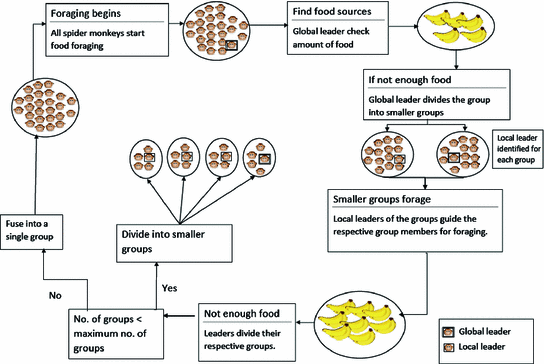

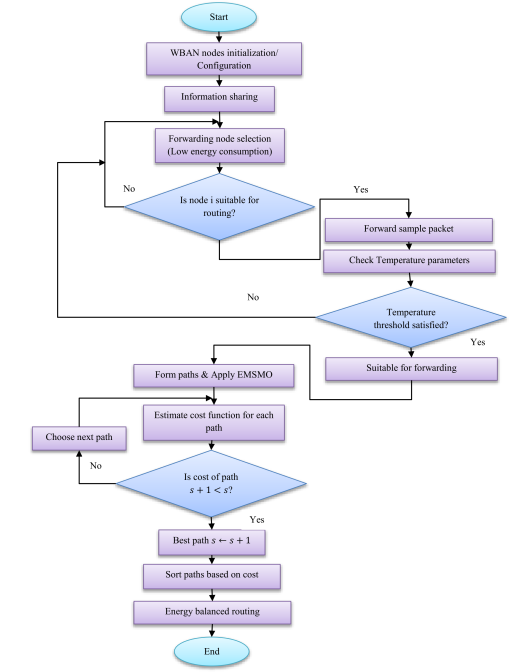

###Solution

In [ ]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual=[]
        self.convergence = []
        self.optimizer=""
        self.objfname=""
        self.startTime=0
        self.endTime=0
        self.executionTime=0
        self.lb=0
        self.ub=0
        self.dim=0
        self.popnum=0
        self.error =0
        self.feval=0
        self.maxiers=0

##EOCC + SMO

In [ ]:
class benchmarks():
  import numpy
  import math

  # define the function blocks
  def F1(x):
      s=numpy.sum(x**2)
      return s
  #More objective functions can be inserted here

  #Ex: def F1(x):
  #       s=numpy.sum(sin(x))
  #       return s

  # define the function parameters
  def getFunctionDetails(a):

      # [name, lb, ub, dim, acc_err, obj_val, temp, cost]
      param = {	0: ["F1",-100,100,30,1.0e-5,0, 37.8, 0.05],
              }
              # add values into param dict depending on which objective function to use and what are the parameters associated with it
      return param.get(a, "nothing")

In [ ]:
from __future__ import division
import time
import random
import numpy
import math

class SMOFunc():
    def __init__(self,objf1,lb1,ub1,dim1,PopSize1,acc_err1,iters1, temperature_threshold , costfunction):
        self.PopSize=PopSize1 #population size
        self.dim=dim1 #dimensions
        self.acc_err=acc_err1 #accuracy error  suitable node
        self.temperature_threshold=temperature_threshold #temperature_threshold
        self.costfunction=costfunction #costfunction
        self.lb=lb1 #lower bound
        self.ub=ub1 #ubber bound
        self.objf=objf1 #objective function
        self.pos=numpy.zeros((PopSize1,dim1)) #position array
        self.fun_val = numpy.zeros(PopSize1) #function evaluation for every monkey pos
        self.fitness = numpy.zeros(PopSize1) #fitness array of every monkey
        self.gpoint = numpy.zeros((PopSize1,2))
        self.prob=numpy.zeros(PopSize1) #probabibiility values
        self.LocalLimit=dim1*PopSize1; #LocalLeaderLimit
        self.GlobalLimit=PopSize1; #GlobalLeaderLimit
        self.fit = numpy.zeros(PopSize1)
        self.MinCost=numpy.zeros(iters1)
        self.Bestpos=numpy.zeros(dim1)
        self.group = 0
        self.func_eval=0
        self.part=1
        self.max_part=5
        self.cr=0.1


    # ====== Function: CalculateFitness() ========= #
    def CalculateFitness(self,fun1):
      if fun1 >= 0:
        result = (1/(fun1+1))
      else:
        result=(1+math.fabs(fun1))
      return result
    #================ X X X ===================== #

    # ==================================== Function: Initialization() ============================================ #
    def initialize(self):
        global GlobalMin, GlobalLeaderPosition, GlobalLimitCount, LocalMin, LocalLimitCount, LocalLeaderPosition
        S_max=int(self.PopSize/2)
        LocalMin = numpy.zeros(S_max)
        LocalLeaderPosition=numpy.zeros((S_max,self.dim))
        LocalLimitCount=numpy.zeros(S_max)
        for i in range(self.PopSize):
            for j in range(self.dim):
                if type(self.ub)==int:
                    self.pos[i,j]=random.random()*(self.ub-self.lb)+self.lb
                else:
                    self.pos[i,j]=random.random()*(self.ub[j]-self.lb[j])+self.lb[j]
        #Randomly initialize Spider Monkey positions
        #Calculate objective function for each particle
        for i in range(self.PopSize):
            # Performing the bound checking
            self.pos[i,:]=numpy.clip(self.pos[i,:], self.lb, self.ub)
            self.fun_val[i]=self.objf(self.pos[i,:])
            self.func_eval+=1
            self.fitness[i]=self.CalculateFitness(self.fun_val[i])

        # Initialize Global Leader Learning
        GlobalMin=self.fun_val[0]
        GlobalLeaderPosition=self.pos[0,:]
        GlobalLimitCount=0 #initially

        # Initialize Local Leader Learning
        for k in range(self.group):
            LocalMin[k]=self.fun_val[int(self.gpoint[k,0])]
            LocalLimitCount[k]=0 #initially
            LocalLeaderPosition[k,:]=self.pos[int(self.gpoint[k,0]),:]
    # ============================================ X X X ======================================================= #


    # =========== Function: CalculateProbabilities() ============ #
    def CalculateProbabilities(self):
        maxfit=self.fitness[0]
        i=1
        while(i<self.PopSize):
            if (self.fitness[i]>maxfit):
                maxfit=self.fitness[i]
            i+=1
        for i in range(self.PopSize):
            self.prob[i]=(0.9*(self.fitness[i]/maxfit))+0.1
    # ========================== X X X ======================== #

    # ================= Function: create_group() ================ #
    def create_group(self):
        g=0
        lo=0
        while(lo < self.PopSize):
            hi= lo+int(self.PopSize/self.part)
            self.gpoint[g,0]=lo
            self.gpoint[g,1]=hi
            if((self.PopSize-hi)<(int(self.PopSize/self.part))):
                self.gpoint[g,1]=(self.PopSize-1)
            g=g+1
            lo=hi+1
        self.group = g
    # ========================== X X X ======================== #

    # ================= Function: LocalLearning() ================ #
    def LocalLearning(self):
        global LocalMin, LocalLimitCount, LocalLeaderPosition
        S_max=int(self.PopSize/2)
        OldMin = numpy.zeros(S_max)
        for k in range(self.group):
            OldMin[k]=LocalMin[k]

        for  k in range(self.group):
            i=int(self.gpoint[k,0])
            while (i<=int(self.gpoint[k,1])):
                if (self.fun_val[i]<LocalMin[k]):
                    LocalMin[k]=self.fun_val[i]
                    LocalLeaderPosition[k,:]=self.pos[i,:]
                i=i+1

        for k in range(self.group):
            if (math.fabs(OldMin[k]-LocalMin[k])<self.acc_err):
                LocalLimitCount[k]=LocalLimitCount[k]+1
            else:
                LocalLimitCount[k]=0
    # ========================== X X X ======================== #

    # ================= Function: GlobalLearning() ================ #
    def GlobalLearning(self):
        global GlobalMin, GlobalLeaderPosition, GlobalLimitCount
        G_trial=GlobalMin
        for i in range(self.PopSize):
            if (self.fun_val[i] < GlobalMin):
                GlobalMin=self.fun_val[i]
                GlobalLeaderPosition=self.pos[i,:]

        if(math.fabs(G_trial-GlobalMin)<self.acc_err):
            GlobalLimitCount=GlobalLimitCount+1
        else:
            GlobalLimitCount=0
    # ========================== X X X ======================== #

    # ================= Function: LocalLeaderPhase() ================ #
    def LocalLeaderPhase(self,k):
        global LocalLeaderPosition
        new_position=numpy.zeros((1,self.dim))
        lo=int(self.gpoint[k,0])
        hi=int(self.gpoint[k,1])
        i=lo
        while(i <=hi):
            while True:
                PopRand=int((random.random()*(hi-lo)+lo))
                if (PopRand != i):
                    break
            for j in range(self.dim):
                if (random.random() >= self.cr):
                    new_position[0,j]=self.pos[i,j]+(LocalLeaderPosition[k,j]-self.pos[i,j])*(random.random())+(self.pos[PopRand,j]-self.pos[i,j])*(random.random()-0.5)*2
                else:
                    new_position[0,j]=self.pos[i,j]
            new_position=numpy.clip(new_position, self.lb, self.ub)

            ObjValSol=self.objf(new_position)
            self.func_eval+=1
            FitnessSol=self.CalculateFitness(ObjValSol)
            if (FitnessSol>self.fitness[i]):
                self.pos[i,:]=new_position
                self.fun_val[i]=ObjValSol
                self.fitness[i]=FitnessSol
            i+=1
    # ========================== X X X ======================== #

    # ================= Function: GlobalLeaderPhase() ================ #
    def GlobalLeaderPhase(self,k):
        global GlobalLeaderPosition
        new_position=numpy.zeros((1,self.dim))
        lo=int(self.gpoint[k,0])
        hi=int(self.gpoint[k,1])
        i=lo
        l=lo
        while(l<hi):
            if (random.random() < self.prob[i]):
                l+=1
                while True:
                    PopRand=int(random.random()*(hi-lo)+lo)
                    if (PopRand != i):
                        break
                param2change=int(random.random()*self.dim)
                new_position=self.pos[i,:]
                new_position[param2change]=self.pos[i,param2change]+(GlobalLeaderPosition[param2change]-self.pos[i,param2change])*(random.random())+(self.pos[PopRand,param2change]-self.pos[i,param2change])*(random.random()-0.5)*2
                new_position=numpy.clip(new_position, self.lb, self.ub)
                ObjValSol=self.objf(new_position)
                self.func_eval+=1
                FitnessSol=self.CalculateFitness(ObjValSol)
                if (FitnessSol>self.fitness[i]):
                    self.pos[i,:]=new_position
                    self.fun_val[i]=ObjValSol
                    self.fitness[i]=FitnessSol
            i+=1
            if (i==(hi)):
                i=lo
    # ========================== X X X ======================== #

    # ================= Function: GlobalLeaderDecision() ================ #
    def GlobalLeaderDecision(self):
        global GlobalLimitCount
        if(GlobalLimitCount> self.GlobalLimit):
            GlobalLimitCount=0
            if(self.part<self.max_part):
                self.part=self.part+1
                self.create_group()
                self.LocalLearning()
            else:
                self.part=1
                self.create_group()
                self.LocalLearning()
    # ========================== X X X ======================== #

    # ================= Function: LocalLeaderDecision() ================ #
    def LocalLeaderDecision(self):
        global GlobalLeaderPosition, LocalLimitCount, LocalLeaderPosition
        for k in range(self.group):
            if(LocalLimitCount[k]>self.LocalLimit):
                i=self.gpoint[k,0]
                while(i<=int(self.gpoint[k,1])):
                    for j in range(self.dim):
                        if (random.random()>= self.cr):
                            if type(self.ub)==int:
                                self.pos[i,j]=random.random()*(self.ub-self.lb)+self.lb
                            else:
                                self.pos[i,j]=random.random()*(self.ub[j]-self.lb[j])+self.lb[j]
                        else:
                            self.pos[i,j]=self.pos[i,j]+(GlobalLeaderPosition[j]-self.pos[i,j])*random.random()+(self.pos[i,j]-LocalLeaderPosition[k,j])*random.random()
                    self.pos[i,:]=numpy.clip(self.pos[i,:], self.lb, self.ub)
                    self.fun_val[i]=self.objf(self.pos[i,:])
                    self.func_eval+=1
                    self.fitness[i]=self.CalculateFitness(self.fun_val[i])
                    i+=1
                LocalLimitCount[k]=0
    # ========================== X X X ======================== #

    # ==================================== Main() ===================================== #
    def main(objf1,lb1,ub1,dim1,PopSize1,iters,acc_err1,obj_val,succ_rate,mean_feval, temp,cost):
        smo=SMOFunc(objf1,lb1,ub1,dim1,PopSize1,acc_err1,iters, temp, cost)
        s=solution()
        print("SMO is optimizing  \""+smo.objf.__name__+"\"")
        timerStart=time.time()
        s.startTime=time.strftime("%Y-%m-%d-%H-%M-%S")

        # =========================== Calling: initialize() =========================== #
        smo.initialize()

        # ========================== Calling: GlobalLearning() ======================== #
        smo.GlobalLearning()

        # ========================= Calling: LocalLearning() ========================== #
        smo.LocalLearning()

        # ========================== Calling: create_group() ========================== #
        smo.create_group()

        # ================================= Looping ================================== #
        for l in range(iters):
            for k in range(smo.group):
                # ==================== Calling: LocalLeaderPhase() =================== #
                smo.LocalLeaderPhase(k)

            # =================== Calling: CalculateProbabilities() ================== #
            smo.CalculateProbabilities()

            for k in range(smo.group):
                # ==================== Calling: GlobalLeaderPhase() ================== #
                smo.GlobalLeaderPhase(k)

            # ======================= Calling: GlobalLearning() ====================== #
            smo.GlobalLearning()

            # ======================= Calling: LocalLearning() ======================= #
            smo.LocalLearning()

            # ================== Calling: LocalLeaderDecision() ====================== #
            smo.LocalLeaderDecision()

            # ===================== Calling: GlobalLeaderDecision() ================== #
            smo.GlobalLeaderDecision()

            # ======================= Updating: 'cr' parameter ======================= #
            smo.cr = smo.cr + (0.4/iters)

            # ====================== Saving the best individual ====================== #
            smo.MinCost[l] = GlobalMin
            Bestpos=smo.pos[1,:]
            gBestScore=GlobalMin


            # ================ Displaying the fitness of each iteration ============== #
            if (l%1==0):
                  print(['At iteration '+ str(l+1)+ ' the best fitness is '+ str(gBestScore)]);

            # ====================== Checking: acc_error ============================ #
            if(math.fabs(GlobalMin-obj_val)<=smo.acc_err):
                succ_rate+=1
                mean_feval=mean_feval+smo.func_eval
                break
        # ========================= XXX Ending of Loop XXX ========================== #

        # =========================== XX Result saving XX =========================== #
        error1=math.fabs(GlobalMin-obj_val)
        timerEnd=time.time()
        s.endTime=time.strftime("%Y-%m-%d-%H-%M-%S")
        s.executionTime=timerEnd-timerStart
        s.convergence=smo.MinCost
        s.optimizer="SMOFunc"
        s.error = error1
        s.feval=smo.func_eval
        s.objfname=smo.objf.__name__

        return s, succ_rate,mean_feval

        # ================================ X X X =================================== #


In [ ]:
def training_qlearn():
  #define training parameters
  epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
  discount_factor = 0.9 #discount factor for future rewards = gamma
  learning_rate = 0.9 #the rate at which the agent should learn =alpha

  #run through 1000 training episodes
  for episode in range(1000): #epoch
    #get the starting location for this episode
    row_index, column_index = get_starting_location()
    #continue taking actions (i.e., moving) until we reach a terminal state
    #(i.e., until we reach the item packaging area or crash into an item storage location)
    while not is_terminal_state(row_index, column_index):
      #choose which action to take (i.e., where to move next)
      action_index = get_next_action(row_index, column_index, epsilon)
      #perform the chosen action, and transition to the next state (i.e., move to the next location)
      old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
      row_index, column_index = get_next_location(row_index, column_index, action_index)
      #receive the reward for moving to the new state, and calculate the temporal difference
      reward = rewards[row_index, column_index]
      old_q_value = q_values[old_row_index, old_column_index, action_index]
      temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value
      #update the Q-value for the previous state and action pair
      new_q_value = old_q_value + (learning_rate * temporal_difference)
      q_values[old_row_index, old_column_index, action_index] = new_q_value
  #print('Training complete!')

#**Test and Evaluate Q-Learning**

In [ ]:
def test_agent(Q, env=11, n_tests=100, n_actions=8, delay=0.1):
    for test in range(n_tests):
        s = env.reset()
        done = False
        epsilon = 0
        total_reward = 0
        while True:
            time.sleep(delay)
            env.render()
            a = get_next_action(Q, epsilon, n_actions, s, train=True)
            print(f"Chose action {a} for state {s}")
            s, reward, done, info = env.step(a)
            total_reward += reward
            if done:
                print(f"Episode reward: {total_reward}")
                time.sleep(1)
                break

#Acknowledgement  

In [ ]:
def receivePacket(sensors ,model, receiver, packetType):
    if (packetType == 'Hello'):
        PacketSize = model.HelloPacketLen
    else:
        PacketSize = model.DataPacketLen

    #Energy dissipated from sensors for Receive a packet
    if (receiver.type == 'N'):
        receiver.E -= (model.ERX * PacketSize)
    else:
        receiver.E -= (model.w2 * model.ERX * PacketSize)

#SAR

In [ ]:
import math
import cmath
def SAR(R, t):
    fi = 1.79
    miu = 4*math.pi*10**7
    ro = 1040
    omega = 2.4*10**-9
    eps=52.73
    I=0.1
    R=R/100
    alpha = omega*math.sqrt((miu*eps)/2)*(math.sqrt(1 + (fi/(miu*eps))**2 - 1))**(1/2)
    beta = omega*math.sqrt((miu*eps)/2)*(math.sqrt(1 + (fi/(miu*eps)**2 +1 )))**(1/2)
    gamma = alpha + cmath.sqrt(-1) * beta
    SAR = (fi * miu* omega)/(ro*math.sqrt(fi**2 + eps**2 * omega**2)) * ((I*1*1*math.exp(-alpha*R))/(4 *math.pi) * (1/R**2 + abs(gamma)/R))**2

    C = 3600
    delta =  SAR * t/C
    return delta

In [ ]:
import numpy as np
from time import sleep
from datetime import datetime
import time


#settings
count_num=16000
patient_num = 100
sensor_num = 5

#**Q Learning + EOCC TARA**

In [ ]:
import numpy as np
from time import sleep
from datetime import datetime
import time
from random import randrange
import random
import multiprocessing

sensors = [Sensors() for _ in range(6)]
import numpy as np
from time import sleep
from datetime import datetime
import time

training_qlearn()
#settings
count_num=16000
patient_num = 100
sensor_num = 5
temperature=37.8
costfunction=0.05
temp_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
energy_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
packet_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
throughput_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
time_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
elapsed_cache = np.zeros((patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
patients_priority_cache = np.zeros((patient_num),  dtype=object) #Count - Patient - Sensor
sensors_priority_cache = np.zeros((sensor_num),  dtype=object) #Count - Patient - Sensor
sensors_dead_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
power_cache = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor

elapsed_ecg=1
elapsed_o2=2
elapsed_eeg=1
elapsed_blood=1
elapsed_temp=1

import csv #for working with csv files
import numpy #math matrix operations
import time #algo running time
import math #normal math operations


def selector(algo,func_details,popSize,Iter,succ_rate,mean_feval, temperature, costfunction):
    function_name=func_details[0]
    lb=func_details[1]
    ub=func_details[2]
    dim=func_details[3]
    acc_err=func_details[4]
    obj_val=func_details[5]
    temperature=37.8
    costfunction=0.05
    #selection of different parameters

    if(algo==0):
        x,succ_rate,mean_feval=SMOFunc.main(getattr(benchmarks, function_name),lb,ub,dim,popSize,Iter,acc_err,obj_val,succ_rate,mean_feval, temperature, costfunction) #getting attributes from different file

    return x,succ_rate,mean_feval


# Select optimizers
SMO= True # Code by Himanshu Mittal


# Select benchmark function, for more benchmarks functions, F1=True, F2=True and so on
F1=True

optimizer=[SMO] #list of optimizers, for comparison purposes
benchmarkfunc=[F1] #list of functions

# Select number of repetitions for each experiment.
# To obtain meaningful statistical results, usually ~30 independent runs are executed for each algorithm.
NumOfRuns=2

# Select general parameters for all optimizers (population size, number of iterations)
# popsize ~50, iterations ~100
PopulationSize = 10
Iterations= 16000

#Export results ? For testing purposes, export can be turned to false, csv file will not be generated
Export=True

#Automaticly generated name by date and time
ExportToFile="experiment"+time.strftime("%Y-%m-%d-%H-%M-%S")+".csv"

# Check if it works at least once
Flag=False

# CSV Header for convergence
CnvgHeader=[]

for l in range(0,Iterations):
	CnvgHeader.append("Iter"+str(l+1))

mean_error=0
total_feval=0 #feval=function eval
mean1=0
var=0 #variance
sd=0 #std deviations
mean_feval=0
succ_rate=0
GlobalMins=numpy.zeros(NumOfRuns)


for i in range (0, len(optimizer)):
    for j in range (0, len(benchmarkfunc)):
        if((optimizer[i]==True) and (benchmarkfunc[j]==True)): # start experiment if an optimizer and an objective function is selected
            for k in range (0,NumOfRuns):

                func_details=benchmarks.getFunctionDetails(j)
                print("Run: {}".format(k+1)) #to seperate runs
                x,succ_rate,mean_feval=selector(i,func_details,PopulationSize,Iterations,succ_rate,mean_feval, temperature, costfunction)
                mean_error=mean_error+x.error;
                mean1=mean1+x.convergence[-1]
                total_feval=total_feval+x.feval
                GlobalMins[k]=x.convergence[-1]

                if(Export==True):
                    with open(ExportToFile, 'a') as out:
                        writer = csv.writer(out,delimiter=',')
                        if (Flag==False): # just one time to write the header of the CSV file
                            header= numpy.concatenate([["Optimizer","objfname","startTime","EndTime","ExecutionTime"],CnvgHeader])
                            writer.writerow(header) #write into csv
                        a=numpy.concatenate([[x.optimizer,x.objfname,x.startTime,x.endTime,x.executionTime],x.convergence])
                        writer.writerow(a)
                    out.close()

                Flag=True # at least one experiment
            mean1=mean1/NumOfRuns
            mean_error=mean_error/NumOfRuns
            if(succ_rate>0):
                mean_feval=mean_feval/succ_rate
            total_feval=total_feval/NumOfRuns
            for k in range (NumOfRuns):
                var=var + math.pow((GlobalMins[k]-mean1),2)
            var=var/NumOfRuns
            sd=math.sqrt(var)
            # print("values after executing are: \n Mean Error \t Mean Function eval \t Total Function eval \t Variance \t STD \n",(mean_error,mean_feval,total_feval,var,sd))
            print("Values after executing SMO: \n Mean Error:{} \n Mean Function eval:{} \n Total Function eval:{} \n Variance:{} \n STD:{}".format(mean_error,mean_feval,total_feval,var,sd))
print(sd, var, succ_rate, mean_feval, x)
if (Flag==False): # Faild to run at least one experiment
    print("No Optimizer or Cost function is selected. Check lists of available optimizers and cost functions")

time_now = datetime.now()
elapsed = 0
for count in range(count_num):        #Count
  print('iteration: ', count+1)
  for patient in range(patient_num):  #Patient
    if patient%2==0:
      section='CCU - Critical - ECG + O2'
    elif patient%3==0:
      section='ICU - Critical - EEG + Blood Pressure'
    elif patient%5==0:
      section='General - Critical - Temperature'
    else:
      section='Normal Internal'

    print('Patient: ', patient, '- Section: ', section)
    for sensor in range(sensor_num):  #Sensor

      sensors[sensor].Configuration(sensor)
      if sensor==0:
        if count==0:
          status='ECG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          #energy Consumption
          #Ekd    = Erx_elec*kd**2 + Etx_kd
          #Etx_kd = Etx_elec*k + Eamp *k *d**2
          #Ekd    = Erx_elec*k* d**2 +  Etx_elec*k + Eamp *k *d**2

          #Erx_elec = 36.1*0.000000001
          #Etx_elec = 16.7*0.000000001
          #Eamp = 1.97*0.000000001
          #k=8
          #d=0.04
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count, patient, sensor] + float(sensors[sensor].E) - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('ECG shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] <= 0  or temp_cache[count, patient, sensor] > 38):
            status='ECG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] = time_cache[count, patient, sensor] -  time_cache[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='ECG Reset'
              print('ECG shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
        elif count>0:
          status='ECG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] = sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('ECG shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] < 0  or temp_cache[count, patient, sensor] > 38):
            status='ECG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] =    elapsed_ecg*(sensors[sensor].sleep*10**6) -count
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              elapsed_ecg=elapsed_ecg+1
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='ECG Reset'
              print('ECG shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
        if energy_cache[count, patient, sensor] == 0:
          sensors_dead_cache[sensor] +=1
          print('ECG sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: ECG  - Temperature(iter:',count+1 ,'): ',  round(temp_cache[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache[count, patient, sensor], status)


      elif sensor==1:
        if count==0:
          status='O2 Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('O2 shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] <= 0  or temp_cache[count, patient, sensor] >= 38):
            status='O2 Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] = time_cache[count, patient, sensor] -  time_cache[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='O2 Reset'
              print('O2 shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
        elif count>0:
          status='O2 Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('O2 shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] < 0  or temp_cache[count, patient, sensor] > 38):
            status='O2 Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] =    elapsed_o2*( sensors[sensor].sleep*10**6) -count
            if elapsed_cache[patient, sensor] > 2:
              elapsed_o2=elapsed_o2+1
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='O2 Reset'
              print('O2 shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
        if energy_cache[count, patient, sensor] == 0:
          sensors_dead_cache[sensor] +=1
          print('O2 sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: O2   - Temperature(iter:',count+1 ,'): ',  round(temp_cache[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache[count, patient, sensor], status)

      elif sensor==2:
        if count==0:
          status='EEG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] = sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('EEG shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] <= 0  or temp_cache[count, patient, sensor] >= 38):
            status='EEG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] = time_cache[count, patient, sensor] -  time_cache[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='EEG Reset'
              print('EEG shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
        elif count>0:
          status='EEG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('EEG shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] < 0  or temp_cache[count, patient, sensor] > 38):
            status='EEG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] =    elapsed_eeg*(sensors[sensor].sleep*10**6) - count
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              elapsed_eeg=elapsed_eeg+1
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='EEG Reset'
              print('EEG shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
        if energy_cache[count, patient, sensor] == 0:
          sensors_dead_cache[sensor] +=1
          print('EEG sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: EEG  - Temperature(iter:',count+1 ,'): ',  round(temp_cache[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache[count, patient, sensor] , status)


      elif sensor==3:
        if count==0:
          status='Blood Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('Blood shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] <= 0  or temp_cache[count, patient, sensor] >= 38):
            status='Blood Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] = time_cache[count, patient, sensor] -  time_cache[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='Blood Reset'
              print('Blood shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
        elif count>0:
          status='Blood Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('Blood shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] < 0  or temp_cache[count, patient, sensor] > 38):
            status='Blood Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] =   elapsed_blood*(sensors[sensor].sleep*10**6) - count
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              elapsed_blood=elapsed_blood+1
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='Blood Reset'
              print('Blood shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
        if energy_cache[count, patient, sensor] == 0:
          sensors_dead_cache[sensor] +=1
          print('Blood sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: Blood- Temperature(iter:',count+1 ,'): ',  round(temp_cache[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache[count, patient, sensor],  status)

      elif sensor==4:
        if count==0:
          status='Temp Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('Temp shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] < 0  or temp_cache[count, patient, sensor] > 38):
            status='Temp Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] = time_cache[count, patient, sensor] -  time_cache[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache[patient, sensor] > 2:
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='Temp Reset'
              print('Temp shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=packet_cache[count, patient, sensor]
        elif count>0:
          status='Temp Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache[count, patient, sensor] = temp_cache[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache[count, patient, sensor] = energy_cache[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache[count, patient, sensor] > 0  and temp_cache[count, patient, sensor] <38):
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
            patients_priority_cache[patient] = random.randint(0, 100)
            sensors_priority_cache[sensor] =sensors[sensor].priority
            shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
            print('Temp shortest_path: ', shortest_path)
          elif (energy_cache[count, patient, sensor] < 0  or temp_cache[count, patient, sensor] > 38):
            status='Temp Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache[ patient, sensor] =   elapsed_temp*(sensors[sensor].sleep*10**6)-count
            if elapsed_cache[patient, sensor] > 2:
              elapsed_temp=elapsed_temp+1
              elapsed_cache[ patient, sensor]=0
              temp_cache[count, patient, sensor]=37
              time_cache[count, patient, sensor]=0
              shortest_path=get_shortest_path_SMO(int(sensors[sensor].x), int(sensors[sensor].y), patient, sensor,succ_rate)
              status='Temp Reset'
              print('Temp shortest_path: ', shortest_path)
            packet_cache[count, patient, sensor] = packet_cache[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache[count, patient, sensor]=throughput_cache[count-1, patient, sensor]+packet_cache[count, patient, sensor]
        if energy_cache[count, patient, sensor] == 0:
          sensors_dead_cache[sensor] +=1
          print('Temperature sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: Temp - Temperature(iter:',count+1 ,'): ',  round(temp_cache[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache[count, patient, sensor],  status)


#**EOCC TARA**

In [ ]:
import numpy as np
from time import sleep
from datetime import datetime
import time
from random import randrange
import random
import multiprocessing
sensors = [Sensors() for _ in range(6)]

import numpy as np
from time import sleep
from datetime import datetime
import time


#settings
count_num=16000
patient_num = 100
sensor_num = 5

import csv #for working with csv files
import numpy #math matrix operations
import time #algo running time
import math #normal math operations


def selector(algo,func_details,popSize,Iter,succ_rate,mean_feval, temperature, costfunction):
    function_name=func_details[0]
    lb=func_details[1]
    ub=func_details[2]
    dim=func_details[3]
    acc_err=func_details[4]
    obj_val=func_details[5]
    temperature=37.8
    costfunction=0.05
    #selection of different parameters

    if(algo==0):
        x,succ_rate,mean_feval=SMOFunc.main(getattr(benchmarks, function_name),lb,ub,dim,popSize,Iter,acc_err,obj_val,succ_rate,mean_feval, temperature, costfunction) #getting attributes from different file
    return x,succ_rate,mean_feval


# Select optimizers
SMO= True # Code by Himanshu Mittal


# Select benchmark function, for more benchmarks functions, F1=True, F2=True and so on
F1=True

optimizer=[SMO] #list of optimizers, for comparison purposes
benchmarkfunc=[F1] #list of functions

# Select number of repetitions for each experiment.
# To obtain meaningful statistical results, usually ~30 independent runs are executed for each algorithm.
NumOfRuns=2

# Select general parameters for all optimizers (population size, number of iterations)
# popsize ~50, iterations ~100
PopulationSize = 10
Iterations= 16000

#Export results ? For testing purposes, export can be turned to false, csv file will not be generated
Export=True

#Automaticly generated name by date and time
ExportToFile="experiment"+time.strftime("%Y-%m-%d-%H-%M-%S")+".csv"

# Check if it works at least once
Flag=False

# CSV Header for convergence
CnvgHeader=[]

for l in range(0,Iterations):
	CnvgHeader.append("Iter"+str(l+1))

mean_error=0
total_feval=0 #feval=function eval
mean1=0
var=0 #variance
sd=0 #std deviations
mean_feval=0
succ_rate=0
GlobalMins=numpy.zeros(NumOfRuns)


for i in range (0, len(optimizer)):
    for j in range (0, len(benchmarkfunc)):
        if((optimizer[i]==True) and (benchmarkfunc[j]==True)): # start experiment if an optimizer and an objective function is selected
            for k in range (0,NumOfRuns):

                func_details=benchmarks.getFunctionDetails(j)
                print("Run: {}".format(k+1)) #to seperate runs
                x,succ_rate,mean_feval=selector(i,func_details,PopulationSize,Iterations,succ_rate,mean_feval, temperature, costfunction)
                mean_error=mean_error+x.error;
                mean1=mean1+x.convergence[-1]
                total_feval=total_feval+x.feval
                GlobalMins[k]=x.convergence[-1]

                if(Export==True):
                    with open(ExportToFile, 'a') as out:
                        writer = csv.writer(out,delimiter=',')
                        if (Flag==False): # just one time to write the header of the CSV file
                            header= numpy.concatenate([["Optimizer","objfname","startTime","EndTime","ExecutionTime"],CnvgHeader])
                            writer.writerow(header) #write into csv
                        a=numpy.concatenate([[x.optimizer,x.objfname,x.startTime,x.endTime,x.executionTime],x.convergence])
                        writer.writerow(a)
                    out.close()
                    print("Results of {} run are saved in 'csv' file.".format(k+1))
                Flag=True # at least one experiment
            mean1=mean1/NumOfRuns
            mean_error=mean_error/NumOfRuns
            if(succ_rate>0):
                mean_feval=mean_feval/succ_rate
            total_feval=total_feval/NumOfRuns
            for k in range (NumOfRuns):
                var=var + math.pow((GlobalMins[k]-mean1),2)
            var=var/NumOfRuns
            sd=math.sqrt(var)
            # print("values after executing are: \n Mean Error \t Mean Function eval \t Total Function eval \t Variance \t STD \n",(mean_error,mean_feval,total_feval,var,sd))
            print("Values after executing SMO: \n Mean Error:{} \n Mean Function eval:{} \n Total Function eval:{} \n Variance:{} \n STD:{}".format(mean_error,mean_feval,total_feval,var,sd))

if (Flag==False): # Faild to run at least one experiment
    print("No Optimizer or Cost function is selected. Check lists of available optimizers and cost functions")
temp_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
energy_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
packet_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
throughput_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
time_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
elapsed_cache_2 = np.zeros((patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
patients_priority_cache_2 = np.zeros((patient_num),  dtype=object) #Count - Patient - Sensor
sensors_priority_cache_2 = np.zeros((sensor_num),  dtype=object) #Count - Patient - Sensor
sensors_dead_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor
power_cache_2 = np.zeros((count_num, patient_num, sensor_num),  dtype=object) #Count - Patient - Sensor

elapsed_ecg=1
elapsed_o2=2
elapsed_eeg=1
elapsed_blood=1
elapsed_temp=1

time_now = datetime.now()
elapsed = 0
for count in range(count_num):        #Count
  print('iteration: ', count+1)
  for patient in range(patient_num):  #Patient
    if patient%2==0:
      section='CCU - Critical - ECG + O2'
    elif patient%3==0:
      section='ICU - Critical - EEG + Blood Pressure'
    elif patient%5==0:
      section='General - Critical - Temperature'
    else:
      section='Normal Internal'

    print('Patient: ', patient, '- Section: ', section)
    for sensor in range(sensor_num):  #Sensor

      sensors[sensor].Configuration(sensor)
      if sensor==0:
        if count==0:
          status='ECG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          #energy Consumption
          #Ekd    = Erx_elec*kd**2 + Etx_kd
          #Etx_kd = Etx_elec*k + Eamp *k *d**2
          #Ekd    = Erx_elec*k* d**2 +  Etx_elec*k + Eamp *k *d**2

          #Erx_elec = 36.1*0.000000001
          #Etx_elec = 16.7*0.000000001
          #Eamp = 1.97*0.000000001
          #k=8
          #d=0.04
          #Energy Residual
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count, patient, sensor] + float(sensors[sensor].E) - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] <= 0  or temp_cache_2[count, patient, sensor] > 38):
            status='ECG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] = time_cache_2[count, patient, sensor] -  time_cache_2[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='ECG Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
        elif count>0:
          status='ECG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] = sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] < 0  or temp_cache_2[count, patient, sensor] > 38):
            status='ECG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] =    elapsed_ecg*(sensors[sensor].sleep*10**6) -count
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              elapsed_ecg=elapsed_ecg+1
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='ECG Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
        if energy_cache_2[count, patient, sensor] == 0:
          sensors_dead_cache_2[sensor] +=1
          print('ECG sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: ECG  - Temperature(iter:',count+1 ,'): ',  round(temp_cache_2[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache_2[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache_2[count, patient, sensor], status)


      elif sensor==1:
        if count==0:
          status='O2 Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] <= 0  or temp_cache_2[count, patient, sensor] >= 38):
            status='O2 Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] = time_cache_2[count, patient, sensor] -  time_cache_2[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='O2 Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
        elif count>0:
          status='O2 Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] < 0  or temp_cache_2[count, patient, sensor] > 38):
            status='O2 Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] =    elapsed_o2*( sensors[sensor].sleep*10**6) -count
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_o2=elapsed_o2+1
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='O2 Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
        if energy_cache_2[count, patient, sensor] == 0:
          sensors_dead_cache_2[sensor] +=1
          print('O2 sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: O2   - Temperature(iter:',count+1 ,'): ',  round(temp_cache_2[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache_2[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache_2[count, patient, sensor], status)

      elif sensor==2:
        if count==0:
          status='EEG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] = sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] <= 0  or temp_cache_2[count, patient, sensor] >= 38):
            status='EEG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] = time_cache_2[count, patient, sensor] -  time_cache_2[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='EEG Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
        elif count>0:
          status='EEG Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] < 0  or temp_cache_2[count, patient, sensor] > 38):
            status='EEG Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] =    elapsed_eeg*(sensors[sensor].sleep*10**6) - count
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              elapsed_eeg=elapsed_eeg+1
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='EEG Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
        if energy_cache_2[count, patient, sensor] == 0:
          sensors_dead_cache_2[sensor] +=1
          print('EEG sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: EEG  - Temperature(iter:',count+1 ,'): ',  round(temp_cache_2[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache_2[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache_2[count, patient, sensor] , status)


      elif sensor==3:
        if count==0:
          status='Blood Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] <= 0  or temp_cache_2[count, patient, sensor] >= 38):
            status='Blood Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] = time_cache_2[count, patient, sensor] -  time_cache_2[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='Blood Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
        elif count>0:
          status='Blood Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] < 0  or temp_cache_2[count, patient, sensor] > 38):
            status='Blood Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] =   elapsed_blood*(sensors[sensor].sleep*10**6) - count
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              elapsed_blood=elapsed_blood+1
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='Blood Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
        if energy_cache_2[count, patient, sensor] == 0:
          sensors_dead_cache_2[sensor] +=1
          print('Blood sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: Blood- Temperature(iter:',count+1 ,'): ',  round(temp_cache_2[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache_2[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache_2[count, patient, sensor],  status)

      elif sensor==4:
        if count==0:
          status='Temp Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count, patient, sensor] + sensors[sensor].CurrentTemperature + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count, patient, sensor] + sensors[sensor].E - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] < 0  or temp_cache_2[count, patient, sensor] > 38):
            status='Temp Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] = time_cache_2[count, patient, sensor] -  time_cache_2[count - sensors[sensor].sleep*10**6, patient, sensor]
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='Temp Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=packet_cache_2[count, patient, sensor]
        elif count>0:
          status='Temp Working...'
          d=math.sqrt(((sensors[sensor].x-sensors[5].x)**2)+((sensors[sensor].y-sensors[5].y)**2))
          sar = SAR(d,count)
          inc_temp = sar + sensors[sensor].GrowthTemperature
          inc_temp    = round(inc_temp, 5)
          temp_cache_2[count, patient, sensor] = temp_cache_2[count - 1, patient, sensor] + inc_temp #Count - Patient - Sensor
          Ekd    = sensors[sensor].Erx_elec*sensors[sensor].k* d**2 +  sensors[sensor].Etx_elec*sensors[sensor].k + sensors[sensor].Eamp *sensors[sensor].k *d**2
          Ekd    = round(Ekd, 10)
          energy_cache_2[count, patient, sensor] = energy_cache_2[count - 1, patient, sensor]  - Ekd #Count - Patient - Sensor
          time_cache_2[count, patient, sensor] = (time_now.minute*60+time_now.second)
          if (energy_cache_2[count, patient, sensor] > 0  and temp_cache_2[count, patient, sensor] <38):
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] + 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
            patients_priority_cache_2[patient] = random.randint(0, 100)
            sensors_priority_cache_2[sensor] =sensors[sensor].priority
          elif (energy_cache_2[count, patient, sensor] < 0  or temp_cache_2[count, patient, sensor] > 38):
            status='Temp Sleeping'
            time.sleep(sensors[sensor].sleep) #sleeps for x seconds
            temp_cache_2[count, patient, sensor] = 38 - sensors[sensor].sleep
            elapsed_cache_2[ patient, sensor] =   elapsed_temp*(sensors[sensor].sleep*10**6)-count
            if elapsed_cache_2[patient, sensor] > 2:
              elapsed_temp=elapsed_temp+1
              elapsed_cache_2[ patient, sensor]=0
              temp_cache_2[count, patient, sensor]=37
              time_cache_2[count, patient, sensor]=0
              status='Temp Reset'
            packet_cache_2[count, patient, sensor] = packet_cache_2[count, patient, sensor] - 1 #Count - Patient - Sensor
            throughput_cache_2[count, patient, sensor]=throughput_cache_2[count-1, patient, sensor]+packet_cache_2[count, patient, sensor]
        if energy_cache_2[count, patient, sensor] == 0:
          sensors_dead_cache_2[sensor] +=1
          print('Temperature sensor is not accessible anymore due to zero energy...')
        else:
          print('sensor: Temp - Temperature(iter:',count+1 ,'): ',  round(temp_cache_2[count, patient, sensor], 10), 'Energy(iter:',count+1 ,'): ',round(energy_cache_2[count, patient, sensor], 10), 'Packet(iter:',count+1 ,'): ',packet_cache_2[count, patient, sensor],  status)


#Plot

#Energy Residual

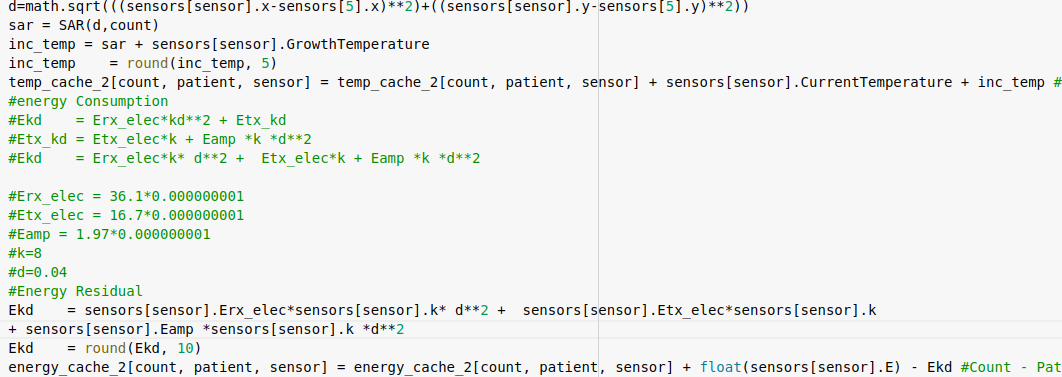

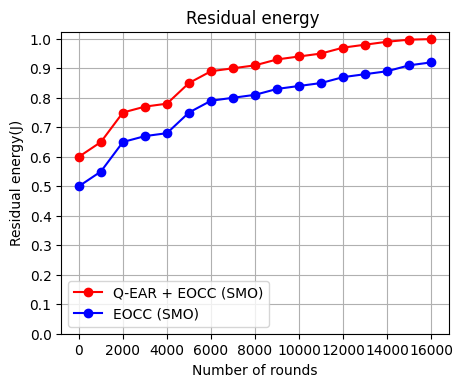

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_energy_1 = energy_cache[0:1000, :, :].mean()/1000
sensor_energy_2 = energy_cache[0:2000, :, :].mean()/1000
sensor_energy_3 = energy_cache[0:3000, :, :].mean()/1000
sensor_energy_4 = energy_cache[0:4000, :, :].mean()/1000
sensor_energy_5 = energy_cache[0:5000, :, :].mean()/1000
sensor_energy_6 = energy_cache[0:6000, :, :].mean()/1000
sensor_energy_7 = energy_cache[0:7000, :, :].mean()/1000
sensor_energy_8 = energy_cache[0:8000, :, :].mean()/1000
sensor_energy_9 = energy_cache[0:9000, :, :].mean()/1000
sensor_energy_10 = energy_cache[0:10000, :, :].mean()/1000
sensor_energy_11 = energy_cache[0:11000, :, :].mean()/1000
sensor_energy_12 = energy_cache[0:12000, :, :].mean()/1000
sensor_energy_13 = energy_cache[0:13000, :, :].mean()/1000
sensor_energy_14 = energy_cache[0:14000, :, :].mean()/1000
sensor_energy_15 = energy_cache[0:15000, :, :].mean()/1000
sensor_energy_16 = energy_cache[0:16000, :, :].mean()/1000
x1 = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
y1 = [0,sensor_energy_1 ,sensor_energy_2,sensor_energy_3,sensor_energy_4,sensor_energy_5,sensor_energy_6,sensor_energy_7,sensor_energy_8,sensor_energy_9,sensor_energy_10,sensor_energy_11,sensor_energy_12,sensor_energy_13,sensor_energy_14,sensor_energy_15,sensor_energy_16 ]
plt.plot(x1, y1, 'r-o')
sensor_energy_1 = energy_cache_2[0:1000, :, :].mean()/1000
sensor_energy_2 = energy_cache_2[0:2000, :, :].mean()/1000
sensor_energy_3 = energy_cache_2[0:3000, :, :].mean()/1000
sensor_energy_4 = energy_cache_2[0:4000, :, :].mean()/1000
sensor_energy_5 = energy_cache_2[0:5000, :, :].mean()/1000
sensor_energy_6 = energy_cache_2[0:6000, :, :].mean()/1000
sensor_energy_7 = energy_cache_2[0:7000, :, :].mean()/1000
sensor_energy_8 = energy_cache_2[0:8000, :, :].mean()/1000
sensor_energy_9 = energy_cache_2[0:9000, :, :].mean()/1000
sensor_energy_10 = energy_cache_2[0:10000, :, :].mean()/1000
sensor_energy_11 = energy_cache_2[0:11000, :, :].mean()/1000
sensor_energy_12 = energy_cache_2[0:12000, :, :].mean()/1000
sensor_energy_13 = energy_cache_2[0:13000, :, :].mean()/1000
sensor_energy_14 = energy_cache_2[0:14000, :, :].mean()/1000
sensor_energy_15 = energy_cache_2[0:15000, :, :].mean()/1000
sensor_energy_16 = energy_cache_2[0:16000, :, :].mean()/1000
x2 = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
y2 = [0,sensor_energy_1 ,sensor_energy_2,sensor_energy_3,sensor_energy_4,sensor_energy_5,sensor_energy_6,sensor_energy_7,sensor_energy_8,sensor_energy_9,sensor_energy_10,sensor_energy_11,sensor_energy_12,sensor_energy_13,sensor_energy_14,sensor_energy_15,sensor_energy_16 ]
plt.plot(x2, y2, 'b-o')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0,2000,4000,6000,8000,10000, 12000, 14000, 16000])
plt.xlabel('Number of rounds')
plt.ylabel('Residual energy(J)')
plt.grid(True)
plt.title("Residual energy ")
plt.legend(['Q-EAR + EOCC (SMO)', 'EOCC (SMO)'])
plt.show()
plt.close()

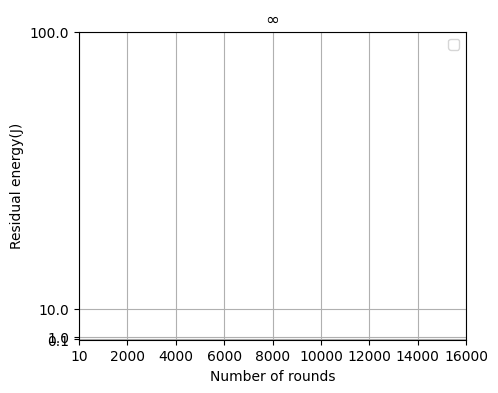

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)

x1 = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
y1 = [0,sensor_energy_1 ,sensor_energy_2,sensor_energy_3,sensor_energy_4,sensor_energy_5,sensor_energy_6,sensor_energy_7,sensor_energy_8,sensor_energy_9,sensor_energy_10,sensor_energy_11,sensor_energy_12,sensor_energy_13,sensor_energy_14,sensor_energy_15,sensor_energy_16 ]
plt.plot(x1, y1, 'r-o')

x2 = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
y2 = [0,sensor_energy_1 ,sensor_energy_2,sensor_energy_3,sensor_energy_4,sensor_energy_5,sensor_energy_6,sensor_energy_7,sensor_energy_8,sensor_energy_9,sensor_energy_10,sensor_energy_11,sensor_energy_12,sensor_energy_13,sensor_energy_14,sensor_energy_15,sensor_energy_16 ]
plt.plot(x2, y2, 'b-o')
plt.yticks([0.1,1,10,100])
plt.xticks([10,2000,4000,6000,8000,10000, 12000, 14000, 16000])
plt.xlabel('Number of rounds')
plt.ylabel('Residual energy(J)')
plt.grid(True)
plt.title("$\infty$")
plt.legend(['D2, s=2p', 'D2, s=3p', 'D2, s=4p', 'D2, s=4p'])
plt.show()
plt.close()

#Throughput

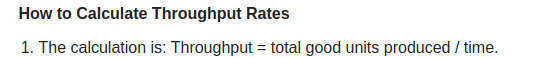

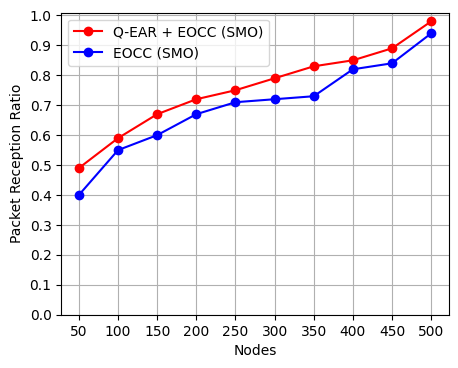

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_throughput_1 =  throughput_cache[:, :, 50].mean()/1000
sensor_throughput_2 =  throughput_cache[:, :, 100].mean()/1000
sensor_throughput_3 =  throughput_cache[:, :, 150].mean()/1000
sensor_throughput_4 =  throughput_cache[:, :, 200].mean()/1000
sensor_throughput_5 =  throughput_cache[:, :, 250].mean()/1000
sensor_throughput_6 =  throughput_cache[:, :, 300].mean()/1000
sensor_throughput_7 =  throughput_cache[:, :, 350].mean()/1000
sensor_throughput_8 =  throughput_cache[:, :, 400].mean()/1000
sensor_throughput_9 =  throughput_cache[:, :, 450].mean()/1000
sensor_throughput_10 = throughput_cache[:, :, 500].mean()/1000
xpoints_throughput = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
ypoints_throughput = [0,sensor_throughput_1 ,sensor_throughput_2 ,sensor_throughput_3 ,sensor_throughput_4 ,sensor_throughput_5 ,sensor_throughput_6 ,sensor_throughput_7 ,sensor_throughput_8 ,sensor_throughput_9 ,sensor_throughput_10,sensor_throughput_11,sensor_throughput_12,sensor_throughput_13,sensor_throughput_14,sensor_throughput_15,sensor_throughput_16]
plt.plot(xpoints_throughput, ypoints_throughput, 'r-o')
sensor_throughput_1 =  throughput_cache[:, :, 50].mean()/1000
sensor_throughput_2 =  throughput_cache[:, :, 100].mean()/1000
sensor_throughput_3 =  throughput_cache[:, :, 150].mean()/1000
sensor_throughput_4 =  throughput_cache[:, :, 200].mean()/1000
sensor_throughput_5 =  throughput_cache[:, :, 250].mean()/1000
sensor_throughput_6 =  throughput_cache[:, :, 300].mean()/1000
sensor_throughput_7 =  throughput_cache[:, :, 350].mean()/1000
sensor_throughput_8 =  throughput_cache[:, :, 400].mean()/1000
sensor_throughput_9 =  throughput_cache[:, :, 450].mean()/1000
sensor_throughput_10 = throughput_cache[:, :, 500].mean()/1000
xpoints_throughput = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
ypoints_throughput = [0,sensor_throughput_1 ,sensor_throughput_2 ,sensor_throughput_3 ,sensor_throughput_4 ,sensor_throughput_5 ,sensor_throughput_6 ,sensor_throughput_7 ,sensor_throughput_8 ,sensor_throughput_9 ,sensor_throughput_10,sensor_throughput_11,sensor_throughput_12,sensor_throughput_13,sensor_throughput_14,sensor_throughput_15,sensor_throughput_16]
plt.plot(xpoints_throughput, ypoints_throughput, 'b-o')
plt.yticks([0,0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80,0.90,1])
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Nodes')
plt.ylabel('Packet Reception Ratio')
plt.grid(True)
plt.legend(['Q-EAR + EOCC (SMO)', 'EOCC (SMO)'])
plt.show()
plt.close()

#End to End Delay

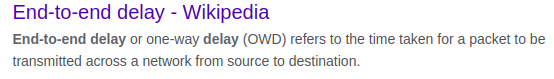

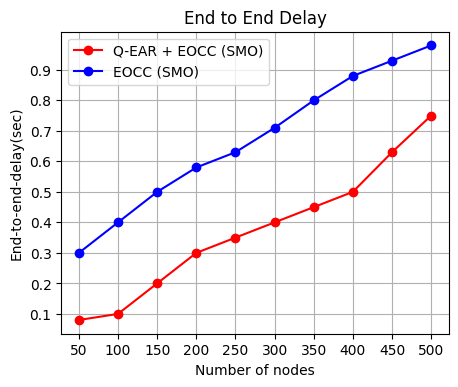

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_time_cache_1 =time_cache[:, :, 50].mean()
sensor_time_cache_2 =time_cache[:, :, 100].mean()
sensor_time_cache_3 =time_cache[:, :, 150].mean()
sensor_time_cache_4 =time_cache[:, :, 200].mean()
sensor_time_cache_5 =time_cache[:, :, 250].mean()
sensor_time_cache_6 =time_cache[:, :, 300].mean()
sensor_time_cache_7 =time_cache[:, :, 350].mean()
sensor_time_cache_8 =time_cache[:, :, 400].mean()
sensor_time_cache_9 =time_cache[:, :, 450].mean()
sensor_time_cache_10=time_cache[:, :, 500].mean()
x1 = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
y1 = [sensor_time_cache_1 ,sensor_time_cache_2 ,sensor_time_cache_3 ,sensor_time_cache_4 ,sensor_time_cache_5 ,sensor_time_cache_6 ,sensor_time_cache_7 ,sensor_time_cache_8 ,sensor_time_cache_9 ,sensor_time_cache_10]
plt.plot(x1,y1, 'r-o')
sensor_time_cache_1 =time_cache_2[:, :, 50].mean()
sensor_time_cache_2 =time_cache_2[:, :, 100].mean()
sensor_time_cache_3 =time_cache_2[:, :, 150].mean()
sensor_time_cache_4 =time_cache_2[:, :, 200].mean()
sensor_time_cache_5 =time_cache_2[:, :, 250].mean()
sensor_time_cache_6 =time_cache_2[:, :, 300].mean()
sensor_time_cache_7 =time_cache_2[:, :, 350].mean()
sensor_time_cache_8 =time_cache_2[:, :, 400].mean()
sensor_time_cache_9 =time_cache_2[:, :, 450].mean()
sensor_time_cache_10=time_cache_2[:, :, 500].mean()
x2 = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
y2 = [sensor_time_cache_1 ,sensor_time_cache_2 ,sensor_time_cache_3 ,sensor_time_cache_4 ,sensor_time_cache_5 ,sensor_time_cache_6 ,sensor_time_cache_7 ,sensor_time_cache_8 ,sensor_time_cache_9 ,sensor_time_cache_10]
plt.plot(x2,y2, 'b-o')
plt.yticks([0.1,0.2,  0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of nodes')
plt.ylabel('End-to-end-delay(sec)')
plt.title("End to End Delay")
plt.grid(True)
plt.legend(['Q-EAR based SMO', 'EOCC-TARA'])
plt.show()
plt.close()

#Nember of Heated Nodes

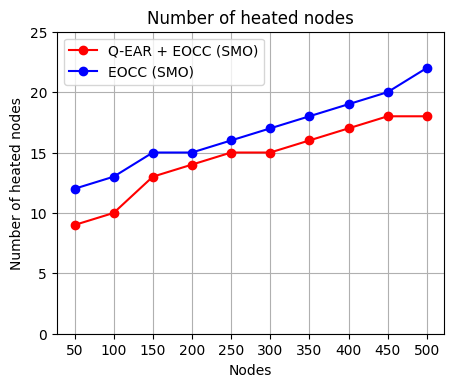

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_temp_cache_1 =temp_cache[:, :, 50].mean()
sensor_temp_cache_2 =temp_cache[:, :, 100].mean()
sensor_temp_cache_3 =temp_cache[:, :, 150].mean()
sensor_temp_cache_4 =temp_cache[:, :, 200].mean()
sensor_temp_cache_5 =temp_cache[:, :, 250].mean()
sensor_temp_cache_6 =temp_cache[:, :, 300].mean()
sensor_temp_cache_7 =temp_cache[:, :, 350].mean()
sensor_temp_cache_8 =temp_cache[:, :, 400].mean()
sensor_temp_cache_9 =temp_cache[:, :, 450].mean()
sensor_temp_cache_10=temp_cache[:, :, 500].mean()
x1 = plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
y1 = [sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ]
plt.plot(x1,y1, 'r-o')
sensor_temp_cache_1 =temp_cache_2[:, :, 50].mean()
sensor_temp_cache_2 =temp_cache_2[:, :, 100].mean()
sensor_temp_cache_3 =temp_cache_2[:, :, 150].mean()
sensor_temp_cache_4 =temp_cache_2[:, :, 200].mean()
sensor_temp_cache_5 =temp_cache_2[:, :, 250].mean()
sensor_temp_cache_6 =temp_cache_2[:, :, 300].mean()
sensor_temp_cache_7 =temp_cache_2[:, :, 350].mean()
sensor_temp_cache_8 =temp_cache_2[:, :, 400].mean()
sensor_temp_cache_9 =temp_cache_2[:, :, 450].mean()
sensor_temp_cache_10=temp_cache_2[:, :, 500].mean()
x2 = plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
y2 = [sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ]
plt.plot(x2,y2, 'b-o')
plt.yticks([0,5,10, 15, 20,25])
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Nodes')
plt.ylabel('Number of heated nodes')
plt.title("Number of heated nodes")
plt.grid(True)
plt.legend(['Q-EAR + EOCC (SMO)', 'EOCC (SMO)'])
plt.show()
plt.close()

#Episode

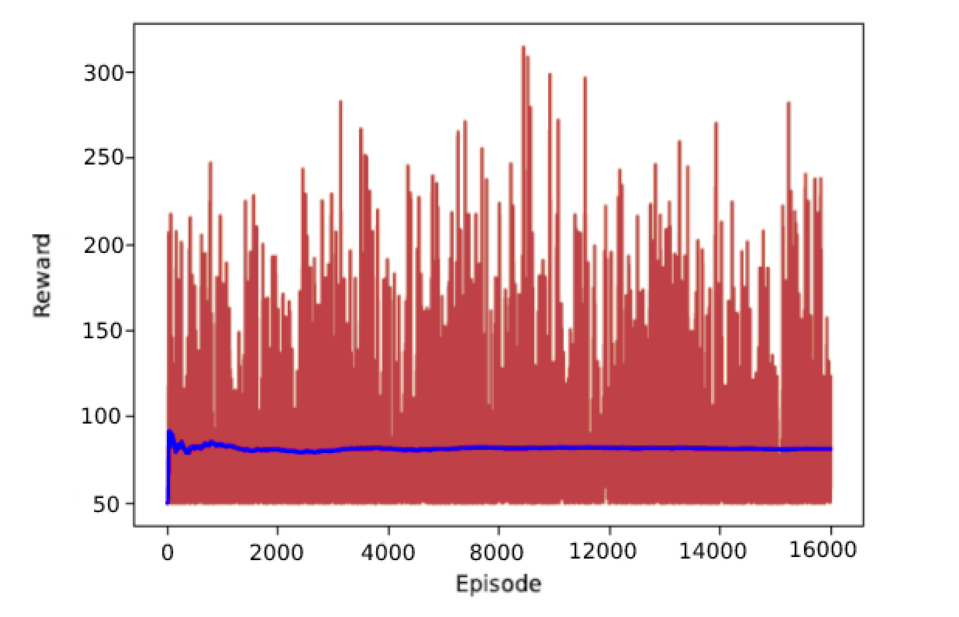

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_rewards_1 =rewards[0:1000, :, :].mean()
sensor_rewards_2 =rewards[0:2000, :, :].mean()
sensor_rewards_3 =rewards[0:3000, :, :].mean()
sensor_rewards_4 =rewards[0:4000, :, :].mean()
sensor_rewards_5 =rewards[0:5000, :, :].mean()
sensor_rewards_6 =rewards[0:6000, :, :].mean()
sensor_rewards_7 =rewards[0:7000, :, :].mean()
sensor_rewards_8 =rewards[0:8000, :, :].mean()
sensor_rewards_9 =rewards[0:9000, :, :].mean()
sensor_rewards_10=rewards[0:10000, :, :].mean()
sensor_rewards_11=rewards[0:11000, :, :].mean()
sensor_rewards_12=rewards[0:12000, :, :].mean()
sensor_rewards_13=rewards[0:13000, :, :].mean()
sensor_rewards_14=rewards[0:14000, :, :].mean()
sensor_rewards_15=rewards[0:15000, :, :].mean()
sensor_rewards_16=rewards[0:16000, :, :].mean()
xpoints_episode = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
ypoints_episode =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_11,sensor_temp_cache_12,sensor_temp_cache_13,sensor_temp_cache_14,sensor_temp_cache_15,sensor_temp_cache_16]
plt.plot(xpoints_episode,ypoints_episode, 'r-o')
xpoints_episode2 = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
ypoints_episode2 =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_11,sensor_temp_cache_12,sensor_temp_cache_13,sensor_temp_cache_14,sensor_temp_cache_15,sensor_temp_cache_16]
plt.plot(xpoints_episode2,ypoints_episode2, 'b-o')
plt.yticks([50, 100, 150, 200, 250, 300])
plt.xticks([0, 2000, 4000, 8000, 12000, 14000, 16000])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

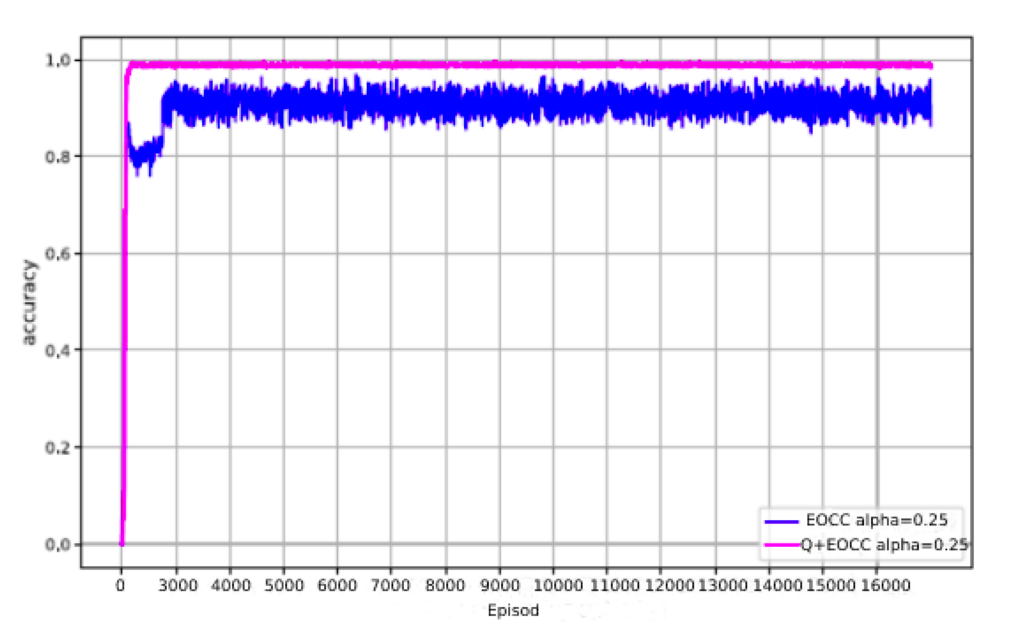

In [ ]:
from keras.models import Sequential, Conv2D
from keras.layers import Activation, Dense, MaxPooling2D, Dropout, Flatten
def accuracy(self):
    model = Sequential()
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
    model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
    return model
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_rewards_1 =rewards[0:1000, :, :].mean()
sensor_rewards_2 =rewards[0:2000, :, :].mean()
sensor_rewards_3 =rewards[0:3000, :, :].mean()
sensor_rewards_4 =rewards[0:4000, :, :].mean()
sensor_rewards_5 =rewards[0:5000, :, :].mean()
sensor_rewards_6 =rewards[0:6000, :, :].mean()
sensor_rewards_7 =rewards[0:7000, :, :].mean()
sensor_rewards_8 =rewards[0:8000, :, :].mean()
sensor_rewards_9 =rewards[0:9000, :, :].mean()
sensor_rewards_10=rewards[0:10000, :, :].mean()
sensor_rewards_11=rewards[0:11000, :, :].mean()
sensor_rewards_12=rewards[0:12000, :, :].mean()
sensor_rewards_13=rewards[0:13000, :, :].mean()
sensor_rewards_14=rewards[0:14000, :, :].mean()
sensor_rewards_15=rewards[0:15000, :, :].mean()
sensor_rewards_16=rewards[0:16000, :, :].mean()
xpoints_episode = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
ypoints_episode =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_11,sensor_temp_cache_12,sensor_temp_cache_13,sensor_temp_cache_14,sensor_temp_cache_15,sensor_temp_cache_16]
plt.plot(xpoints_episode,ypoints_episode, 'r-o')
sensor_rewards_1 =rewards_2[0:1000, :, :].mean()
sensor_rewards_2 =rewards_2[0:2000, :, :].mean()
sensor_rewards_3 =rewards_2[0:3000, :, :].mean()
sensor_rewards_4 =rewards_2[0:4000, :, :].mean()
sensor_rewards_5 =rewards_2[0:5000, :, :].mean()
sensor_rewards_6 =rewards_2[0:6000, :, :].mean()
sensor_rewards_7 =rewards_2[0:7000, :, :].mean()
sensor_rewards_8 =rewards_2[0:8000, :, :].mean()
sensor_rewards_9 =rewards_2[0:9000, :, :].mean()
sensor_rewards_10=rewards_2[0:10000, :, :].mean()
sensor_rewards_11=rewards_2[0:11000, :, :].mean()
sensor_rewards_12=rewards_2[0:12000, :, :].mean()
sensor_rewards_13=rewards_2[0:13000, :, :].mean()
sensor_rewards_14=rewards_2[0:14000, :, :].mean()
sensor_rewards_15=rewards_2[0:15000, :, :].mean()
sensor_rewards_16=rewards_2[0:16000, :, :].mean()
xpoints_episode2 = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000]
ypoints_episode2 =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_11,sensor_temp_cache_12,sensor_temp_cache_13,sensor_temp_cache_14,sensor_temp_cache_15,sensor_temp_cache_16]
plt.plot(xpoints_episode2,ypoints_episode2, 'b-o')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks([0, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

#**Throughput Priority**

#**Throughput Priority - High**

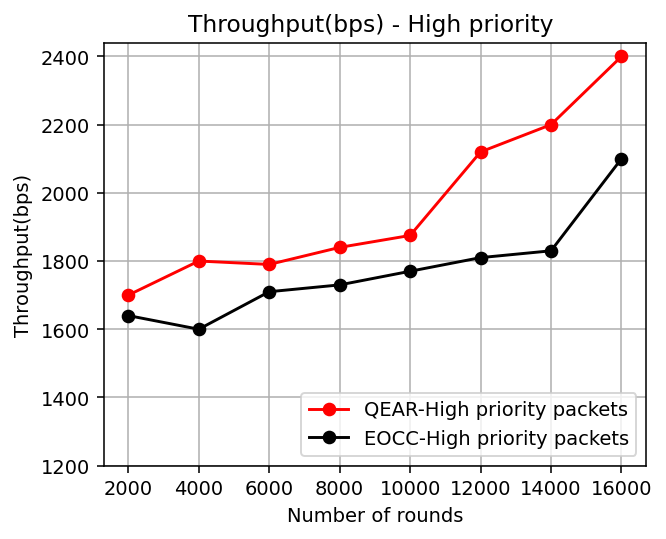

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor = sensors_priority_cache[:]
df_sensor_H = df_sensor.loc[df_sensor[:] >90]
df_patient = patients_priority_cache[:]
df_patient_H = df_patient.loc[df_patient[:] >90]
ypoints_High = df_sensor_H + df_patient_H
plt.plot(ypoints_High, 'r-o')
df_sensor = sensors_priority_cache_2[:]
df_sensor_H = df_sensor.loc[df_sensor[:] >90]
df_patient = patients_priority_cache[:]
df_patient_H = df_patient.loc[df_patient[:] >90]
ypoints_High = df_sensor_H + df_patient_H
plt.plot(ypoints_High, 'k-o')
plt.yticks([1200, 1400, 1600, 1800, 2000, 2200,2400])
plt.xticks([2000,  4000,  6000,  8000,  10000,  12000,  14000,  16000])
plt.xlabel('Number of rounds')
plt.ylabel('Throughput(bps)')
plt.title('Throughput(bps) - High priority ')
plt.grid(True)
plt.legend(['QEAR-High priority packets',  'EOCC-High priority packets'], loc='lower right')
plt.show()

#**Throughput Priority - Medium**

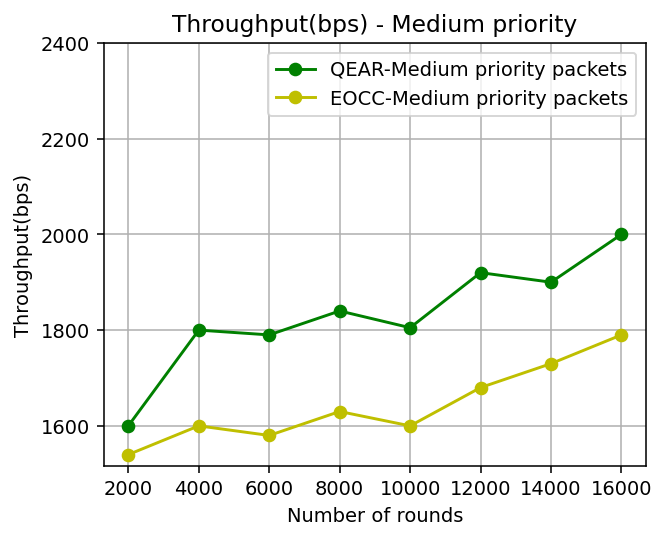

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor = sensors_priority_cache[:]
df_sensor_M = df_sensor.loc[df_sensor[:] <60]
df_patient = patients_priority_cache[:]
df_patient_M = df_sensor.loc[df_sensor[:] <60]
ypoints_Medium = df_sensor_M + df_patient_M
plt.plot(ypoints_Medium, 'g-o')
df_sensor = sensors_priority_cache_2[:]
df_sensor_M = df_sensor.loc[df_sensor[:] <60]
df_patient = patients_priority_cache[:]
df_patient_M = df_sensor.loc[df_sensor[:] <60]
ypoints_Medium = df_sensor_M + df_patient_M
plt.plot(ypoints_Medium, 'y-o')
plt.yticks([1200, 1400, 1600, 1800, 2000])
plt.xticks([2000,  4000,  6000,  8000,  10000,  12000,  14000,  16000])
plt.xlabel('Number of rounds')
plt.ylabel('Throughput(bps)')
plt.title('Throughput(bps)- Medium priority')
plt.legend(['QEAR-Medium priority packets',  'EOCC-Medium priority packets'], loc='upper right')
plt.grid(True)
plt.show()

#**Throughput Priority - Low**

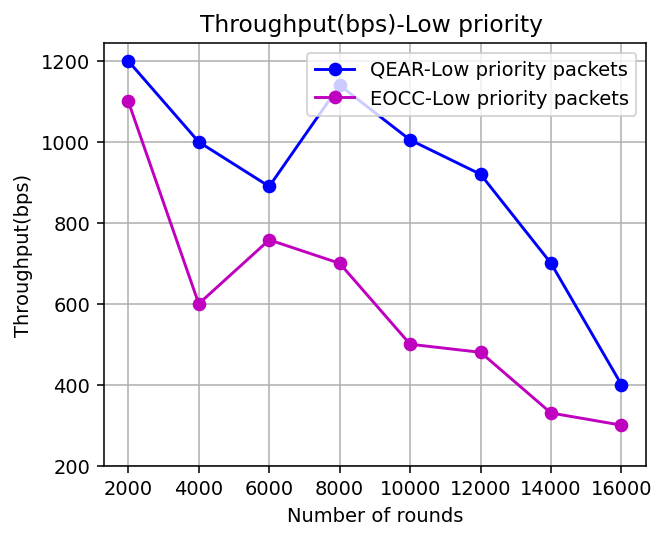

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor = sensors_priority_cache[:]
df_sensor_L = df_sensor.loc[df_sensor[:] <30]
df_patient = patients_priority_cache[:]
df_patient_L = df_sensor.loc[df_sensor[:] <30]
ypoints_Low = df_sensor_L + df_patient_L
plt.plot(ypoints_Low, 'b-o')
df_sensor = sensors_priority_cache_2[:]
df_sensor_L = df_sensor.loc[df_sensor[:] <30]
df_patient = patients_priority_cache[:]
df_patient_L = df_sensor.loc[df_sensor[:] <30]
ypoints_Low = df_sensor_L + df_patient_L
plt.plot(ypoints_Low, 'm-o')
plt.yticks([200, 400, 600,800, 1000,1200, 1400])
plt.xticks([2000,  4000,  6000,  8000,  10000,  12000,  14000,  16000])
plt.xlabel('Number of rounds')
plt.ylabel('Throughput(bps)')
plt.title('Throughput(bps)-Low priority')
plt.legend(['QEAR-Low priority packets',  'EOCC-Low priority packets'], loc='lower right')
plt.show()

#**End to end Priority - High**

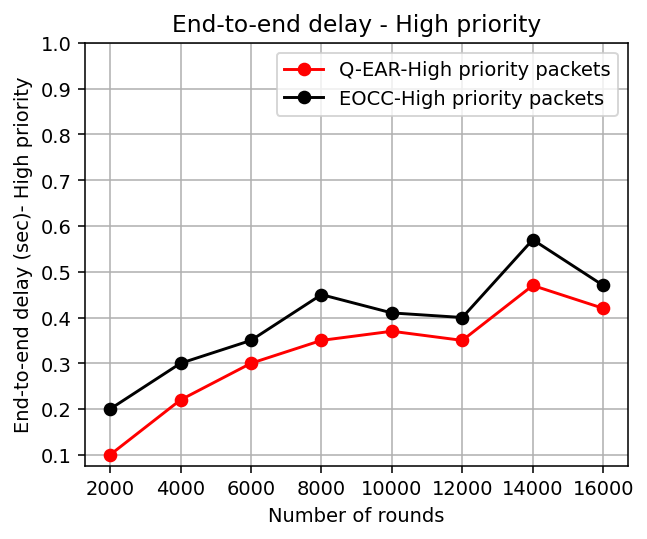

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor = sensors_priority_cache[:]
df_sensor_H = df_sensor.loc[df_sensor[:] >90]
time_cache_H=time_cache[df_sensor_H]
ypoints_High = time_cache_H
plt.plot(ypoints_High, 'r-o')
df_sensor = sensors_priority_cache_2[:]
df_sensor_H = df_sensor.loc[df_sensor[:] >90]
time_cache_H=time_cache[df_sensor_H]
ypoints_High = time_cache_H
plt.plot(ypoints_High, 'k-o')
plt.yticks([0.1,0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([2000,  4000,  6000,  8000,  10000,  12000,  14000,  16000])
plt.xlabel('Number of rounds')
plt.ylabel('End-to-end delay (sec)- High priority')
plt.title('End-to-end delay - High priority')
plt.legend(['Q-EAR-High priority packets', 'EOCC-High priority packets'], loc='upper right')
plt.grid(True)
plt.show()
plt.close()

#**End to end Priority - Medium**

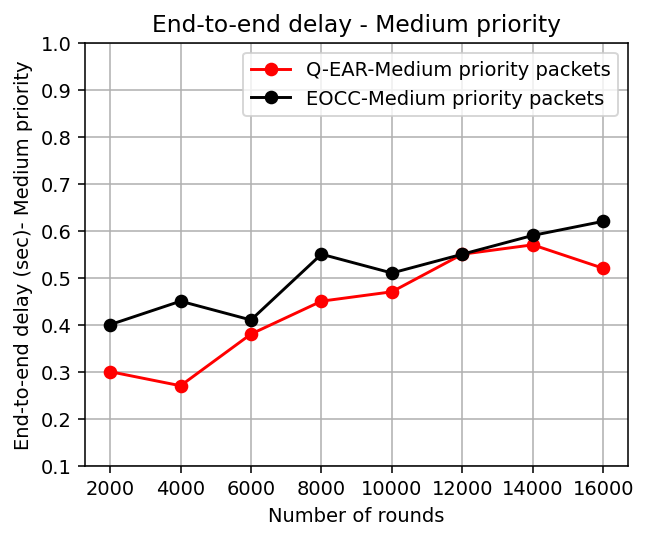

In [ ]:

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor = sensors_priority_cache[:]
df_sensor_L = df_sensor.loc[df_sensor[:] <60]
time_cache_L=time_cache[df_sensor_L]
ypoints_Medium = time_cache_L
plt.plot(ypoints_Medium, 'r-o')
df_sensor = sensors_priority_cache_2[:]
df_sensor_L = df_sensor.loc[df_sensor[:] <60]
time_cache_L=time_cache[df_sensor_L]
ypoints_Medium = time_cache_L
plt.plot(ypoints_Medium, 'k-o')
plt.yticks([0.1,0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([2000,  4000,  6000,  8000,  10000,  12000,  14000,  16000])
plt.xlabel('Number of rounds')
plt.ylabel('End-to-end delay (sec)- Medium priority')
plt.title('End-to-end delay - Medium priority')
plt.legend(['Q-EAR-Medium priority packets', 'EOCC-Medium priority packets'], loc='upper right')
plt.grid(True)
plt.show()
plt.close()

#**End to end Priority - Low**

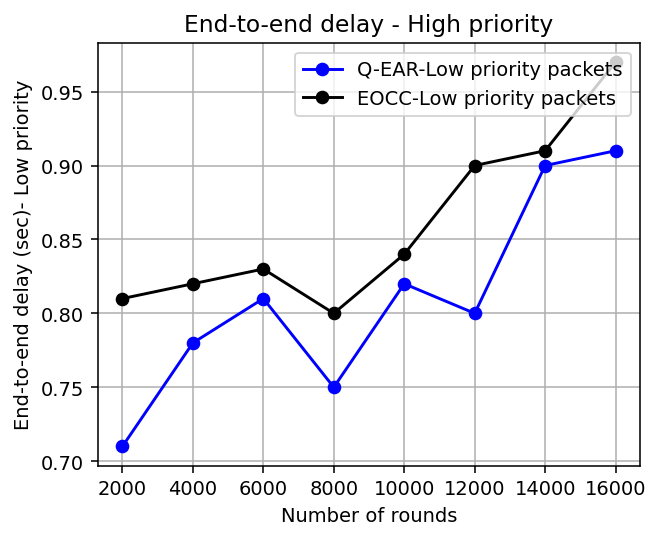

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor = sensors_priority_cache[:]
df_sensor_L = df_sensor.loc[df_sensor[:] <30]
time_cache_L=time_cache[df_sensor_L]
ypoints_High = time_cache_H
ypoints_Low = time_cache_L
plt.plot(ypoints_Low, 'b-o')
df_sensor = sensors_priority_cache_2[:]
df_sensor_L = df_sensor.loc[df_sensor[:] <30]
time_cache_L=time_cache[df_sensor_L]
ypoints_Low = time_cache_L
plt.plot(ypoints_Low, 'm-o')
#plt.yticks([0.01,0.02, 0.03,0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
plt.xticks([2000,  4000,  6000,  8000,  10000,  12000,  14000,  16000])
plt.xlabel('Number of rounds')
plt.ylabel('End-to-end delay (sec)- Low priority')
plt.title('End-to-end delay - Low priority')
plt.legend(['Q-EAR-Low priority packets', 'EOCC-Low priority packets'], loc='upper right')
plt.grid(True)
plt.show()
plt.close()

#Network lifetime

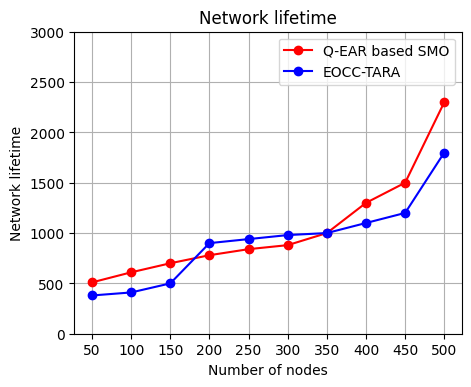

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_dead_cache_1 =sensors_dead_cache[:, :, 50].mean()/1000
sensor_dead_cache_2 =sensors_dead_cache[:, :, 100].mean()/1000
sensor_dead_cache_3 =sensors_dead_cache[:, :, 150].mean()/1000
sensor_dead_cache_4 =sensors_dead_cache[:, :, 200].mean()/1000
sensor_dead_cache_5 =sensors_dead_cache[:, :, 250].mean()/1000
sensor_dead_cache_6 =sensors_dead_cache[:, :, 300].mean()/1000
sensor_dead_cache_7 =sensors_dead_cache[:, :, 350].mean()/1000
sensor_dead_cache_8 =sensors_dead_cache[:, :, 400].mean()/1000
sensor_dead_cache_9 =sensors_dead_cache[:, :, 450].mean()/1000
sensor_dead_cache_10=sensors_dead_cache[:, :, 500].mean()/1000
xpoints_dead = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_dead = [sensor_dead_cache_1,sensor_dead_cache_2 ,sensor_dead_cache_3 ,sensor_dead_cache_4 ,sensor_dead_cache_5 ,sensor_dead_cache_6 ,sensor_dead_cache_7 ,sensor_dead_cache_8 ,ensor_dead_cache_9 ,sensor_dead_cache_10]
plt.plot(xpoints_dead,ypoints_dead, 'r-o')
sensor_dead_cache_1 =sensors_dead_cache_2[:, :, 50].mean()/1000
sensor_dead_cache_2 =sensors_dead_cache_2[:, :, 100].mean()/1000
sensor_dead_cache_3 =sensors_dead_cache_2[:, :, 150].mean()/1000
sensor_dead_cache_4 =sensors_dead_cache_2[:, :, 200].mean()/1000
sensor_dead_cache_5 =sensors_dead_cache_2[:, :, 250].mean()/1000
sensor_dead_cache_6 =sensors_dead_cache_2[:, :, 300].mean()/1000
sensor_dead_cache_7 =sensors_dead_cache_2[:, :, 350].mean()/1000
sensor_dead_cache_8 =sensors_dead_cache_2[:, :, 400].mean()/1000
sensor_dead_cache_9 =sensors_dead_cache_2[:, :, 450].mean()/1000
sensor_dead_cache_10=sensors_dead_cache_2[:, :, 500].mean()/1000
xpoints_dead = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_dead = [sensor_dead_cache_1,sensor_dead_cache_2 ,sensor_dead_cache_3 ,sensor_dead_cache_4 ,sensor_dead_cache_5 ,sensor_dead_cache_6 ,sensor_dead_cache_7 ,sensor_dead_cache_8 ,ensor_dead_cache_9 ,sensor_dead_cache_10]
plt.plot(xpoints_dead,ypoints_dead, 'b-o')
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000])
plt.xlabel('Number of nodes')
plt.ylabel('Network lifetime')
plt.title("Network lifetime")
plt.grid(True)
plt.legend(['Q-EAR based SMO', 'EOCC-TARA'])
plt.show()
plt.close()

#Dead Nodes


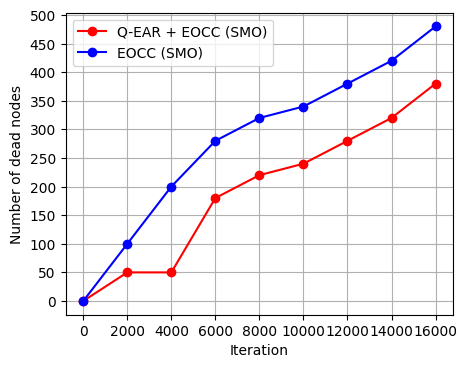

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_dead_cache_1 =sensors_dead_cache[:, :, 50].mean()
sensor_dead_cache_2 =sensors_dead_cache[:, :, 100].mean()
sensor_dead_cache_3 =sensors_dead_cache[:, :, 150].mean()
sensor_dead_cache_4 =sensors_dead_cache[:, :, 200].mean()
sensor_dead_cache_5 =sensors_dead_cache[:, :, 250].mean()
sensor_dead_cache_6 =sensors_dead_cache[:, :, 300].mean()
sensor_dead_cache_7 =sensors_dead_cache[:, :, 350].mean()
sensor_dead_cache_8 =sensors_dead_cache[:, :, 400].mean()
sensor_dead_cache_9 =sensors_dead_cache[:, :, 450].mean()
sensor_dead_cache_10=sensors_dead_cache[:, :, 500].mean()
xpoints_dead = [0,2000,4000,6000,8000,10000, 12000, 14000, 16000]
ypoints_dead = [sensor_dead_cache_1,sensor_dead_cache_2 ,sensor_dead_cache_3 ,sensor_dead_cache_4 ,sensor_dead_cache_5 ,sensor_dead_cache_6 ,sensor_dead_cache_7 ,sensor_dead_cache_8 ,ensor_dead_cache_9 ,sensor_dead_cache_10]
plt.plot(xpoints_dead,ypoints_dead, 'r-o')
sensor_dead_cache_1 =sensors_dead_cache_2[:, :, 50].mean()
sensor_dead_cache_2 =sensors_dead_cache_2[:, :, 100].mean()
sensor_dead_cache_3 =sensors_dead_cache_2[:, :, 150].mean()
sensor_dead_cache_4 =sensors_dead_cache_2[:, :, 200].mean()
sensor_dead_cache_5 =sensors_dead_cache_2[:, :, 250].mean()
sensor_dead_cache_6 =sensors_dead_cache_2[:, :, 300].mean()
sensor_dead_cache_7 =sensors_dead_cache_2[:, :, 350].mean()
sensor_dead_cache_8 =sensors_dead_cache_2[:, :, 400].mean()
sensor_dead_cache_9 =sensors_dead_cache_2[:, :, 450].mean()
sensor_dead_cache_10=sensors_dead_cache_2[:, :, 500].mean()
xpoints_dead = [0,2000,4000,6000,8000,10000, 12000, 14000, 16000]
ypoints_dead = [sensor_dead_cache_1,sensor_dead_cache_2 ,sensor_dead_cache_3 ,sensor_dead_cache_4 ,sensor_dead_cache_5 ,sensor_dead_cache_6 ,sensor_dead_cache_7 ,sensor_dead_cache_8 ,ensor_dead_cache_9 ,sensor_dead_cache_10]
plt.plot(xpoints_dead,ypoints_dead, 'b-o')
plt.yticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xticks([0,2000,4000,6000,8000,10000, 12000, 14000, 16000])
plt.xlabel('Nodes')
plt.ylabel('Number of dead nodes')
plt.grid(True)
plt.legend(['Q-EAR + EOCC (SMO)', 'EOCC (SMO)'])
plt.show()
plt.close()

#Transmission Rate

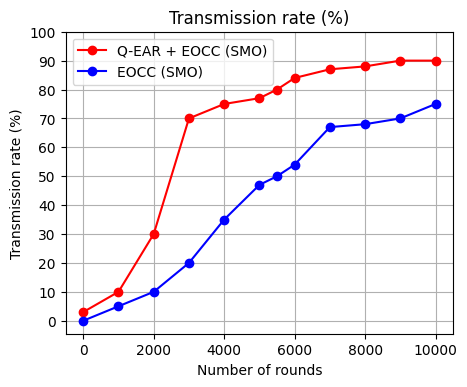

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_throughput_1=throughput_cache[0:1000, :, :].mean()*10**2
sensor_throughput_2=throughput_cache[0:2000, :, :].mean()*10**2
sensor_throughput_3=throughput_cache[0:3000, :, :].mean()*10**2
sensor_throughput_4=throughput_cache[0:4000, :, :].mean()*10**2
sensor_throughput_5=throughput_cache[0:5000, :, :].mean()*10**2
sensor_throughput_6=throughput_cache[0:6000, :, :].mean()*10**2
sensor_throughput_7=throughput_cache[0:7000, :, :].mean()*10**2
sensor_throughput_8=throughput_cache[0:8000, :, :].mean()*10**2
sensor_throughput_9=throughput_cache[0:9000, :, :].mean()*10**2
sensor_throughput_10=throughput_cache[0:10000, :, :].mean()*10**2
xpoints_throughput = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
ypoints_throughput = [0,sensor_throughput_1 ,sensor_throughput_2 ,sensor_throughput_3 ,sensor_throughput_4 ,sensor_throughput_5 ,sensor_throughput_6 ,sensor_throughput_7 ,sensor_throughput_8 ,sensor_throughput_9 ,sensor_throughput_10,sensor_throughput_11,sensor_throughput_12,sensor_throughput_13,sensor_throughput_14,sensor_throughput_15,sensor_throughput_16]
plt.plot(xpoints_throughput,ypoints_throughput, 'r-o')
sensor_throughput_1=throughput_cache_2[0:1000, :, :].mean()*10**2
sensor_throughput_2=throughput_cache_2[0:2000, :, :].mean()*10**2
sensor_throughput_3=throughput_cache_2[0:3000, :, :].mean()*10**2
sensor_throughput_4=throughput_cache_2[0:4000, :, :].mean()*10**2
sensor_throughput_5=throughput_cache_2[0:5000, :, :].mean()*10**2
sensor_throughput_6=throughput_cache_2[0:6000, :, :].mean()*10**2
sensor_throughput_7=throughput_cache_2[0:7000, :, :].mean()*10**2
sensor_throughput_8=throughput_cache_2[0:8000, :, :].mean()*10**2
sensor_throughput_9=throughput_cache_2[0:9000, :, :].mean()*10**2
sensor_throughput_10=throughput_cache_2[0:10000, :, :].mean()*10**2
xpoints_throughput = [0,1000 , 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
ypoints_throughput = [0,sensor_throughput_1 ,sensor_throughput_2 ,sensor_throughput_3 ,sensor_throughput_4 ,sensor_throughput_5 ,sensor_throughput_6 ,sensor_throughput_7 ,sensor_throughput_8 ,sensor_throughput_9 ,sensor_throughput_10,sensor_throughput_11,sensor_throughput_12,sensor_throughput_13,sensor_throughput_14,sensor_throughput_15,sensor_throughput_16]
plt.plot(xpoints_throughput,ypoints_throughput, 'b-o')
plt.yticks([0,10, 20, 30,40,50,60,70,80,90,100])
plt.xticks([0, 2000, 4000,  6000, 8000, 10000])
plt.xlabel('Number of rounds')
plt.ylabel('Transmission rate (%)')
plt.title("Transmission rate (%)")
plt.grid(True)
plt.legend(['Q-EAR + EOCC (SMO)', 'EOCC (SMO)'])
plt.show()
plt.close()

#Energy by Power

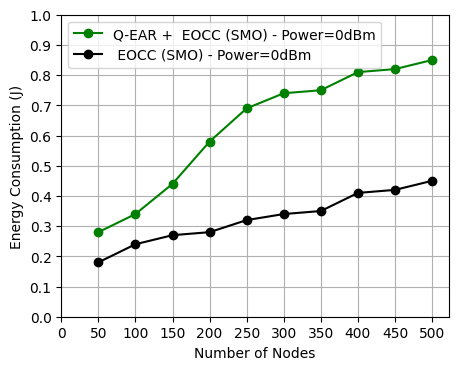

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_H = df_sensor_power.loc[df_sensor_power[:] ==0]
sensor_power_cache_1=energy_cache(df_sensor_H[:, :, 50])
sensor_power_cache_2=energy_cache(df_sensor_H[:, :, 100])
sensor_power_cache_3=energy_cache(df_sensor_H[:, :, 150])
sensor_power_cache_4=energy_cache(df_sensor_H[:, :, 200])
sensor_power_cache_5=energy_cache(df_sensor_H[:, :, 250])
sensor_power_cache_6=energy_cache(df_sensor_H[:, :, 300])
sensor_power_cache_7=energy_cache(df_sensor_H[:, :, 350])
sensor_power_cache_8=energy_cache(df_sensor_H[:, :, 400])
sensor_power_cache_9=energy_cache(df_sensor_H[:, :, 450])
sensor_power_cache_10=energy_cache(df_sensor_H[:, :, 500])
xpoints_H = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_H = [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_H,ypoints_H, 'g-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_H = df_sensor_power.loc[df_sensor_power[:] ==0]
sensor_power_cache_1=energy_cache(df_sensor_H[:,10, :])
sensor_power_cache_2=energy_cache(df_sensor_H[:,20, :])
sensor_power_cache_3=energy_cache(df_sensor_H[:,30, :])
sensor_power_cache_4=energy_cache(df_sensor_H[:,40, :])
sensor_power_cache_5=energy_cache(df_sensor_H[:,50, :])
sensor_power_cache_6=energy_cache(df_sensor_H[:,60, :])
sensor_power_cache_7=energy_cache(df_sensor_H[:,70, :])
sensor_power_cache_8=energy_cache(df_sensor_H[:,80, :])
sensor_power_cache_9=energy_cache(df_sensor_H[:,90, :])
sensor_power_cache_10=energy_cache(df_sensor_H[:,100, :])
xpoints_H = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_H = [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_H,ypoints_H, 'k-o')
plt.yticks([0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of Nodes')
plt.ylabel('Energy Consumption (J)')
plt.grid(True)
plt.legend(['Q-EAR +  EOCC (SMO) - Power=0dBm', ' EOCC (SMO) - Power=0dBm'])
plt.show()
plt.close()

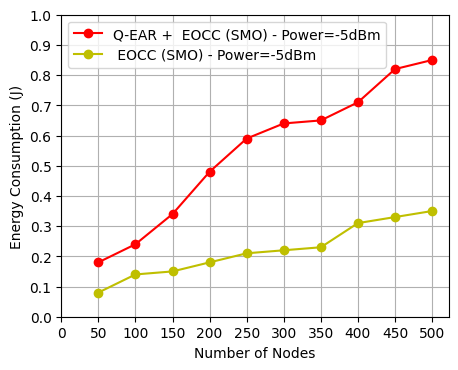

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-5]
sensor_power_cache_1=energy_cache_2(df_sensor_M[:, :, 50])
sensor_power_cache_2=energy_cache_2(df_sensor_M[:, :, 100])
sensor_power_cache_3=energy_cache_2(df_sensor_M[:, :, 150])
sensor_power_cache_4=energy_cache_2(df_sensor_M[:, :, 200])
sensor_power_cache_5=energy_cache_2(df_sensor_M[:, :, 250])
sensor_power_cache_6=energy_cache_2(df_sensor_M[:, :, 300])
sensor_power_cache_7=energy_cache_2(df_sensor_M[:, :, 350])
sensor_power_cache_8=energy_cache_2(df_sensor_M[:, :, 400])
sensor_power_cache_9=energy_cache_2(df_sensor_M[:, :, 450])
sensor_power_cache_10=energy_cache_2(df_sensor_M[:, :, 500])
xpoints_M= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_M= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_M,ypoints_M, 'r-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-5]
sensor_power_cache_1=energy_cache(df_sensor_M[:, :, 50])
sensor_power_cache_2=energy_cache(df_sensor_M[:, :, 100])
sensor_power_cache_3=energy_cache(df_sensor_M[:, :, 150])
sensor_power_cache_4=energy_cache(df_sensor_M[:, :, 200])
sensor_power_cache_5=energy_cache(df_sensor_M[:, :, 250])
sensor_power_cache_6=energy_cache(df_sensor_M[:, :, 300])
sensor_power_cache_7=energy_cache(df_sensor_M[:, :, 350])
sensor_power_cache_8=energy_cache(df_sensor_M[:, :, 400])
sensor_power_cache_9=energy_cache(df_sensor_M[:, :, 450])
sensor_power_cache_10=energy_cache(df_sensor_M[:, :, 500])
xpoints_M= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_M= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_M,ypoints_M, 'y-o')
plt.yticks([0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of Nodes')
plt.ylabel('Energy Consumption (J)')
plt.grid(True)
plt.legend(['Q-EAR +  EOCC (SMO) - Power=-5dBm', ' EOCC (SMO) - Power=-5dBm'])
plt.show()
plt.close()

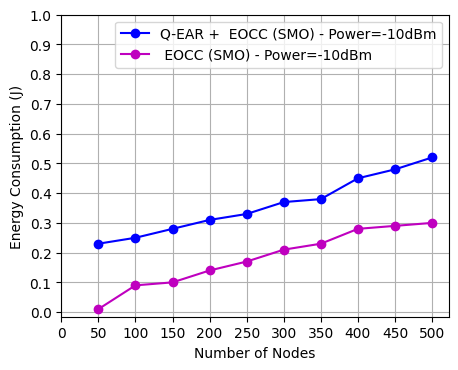

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_L = df_sensor_power.loc[df_sensor_power[:] ==-10]
sensor_power_cache_1=energy_cache_2(df_sensor_L[:, :, 50])
sensor_power_cache_2=energy_cache_2(df_sensor_L[:, :, 100])
sensor_power_cache_3=energy_cache_2(df_sensor_L[:, :, 150])
sensor_power_cache_4=energy_cache_2(df_sensor_L[:, :, 200])
sensor_power_cache_5=energy_cache_2(df_sensor_L[:, :, 250])
sensor_power_cache_6=energy_cache_2(df_sensor_L[:, :, 300])
sensor_power_cache_7=energy_cache_2(df_sensor_L[:, :, 350])
sensor_power_cache_8=energy_cache_2(df_sensor_L[:, :, 400])
sensor_power_cache_9=energy_cache_2(df_sensor_L[:, :, 450])
sensor_power_cache_10=energy_cache_2(df_sensor_L[:, :, 500])
xpoints_L= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_L= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_L,ypoints_L, 'b-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_L = df_sensor_power.loc[df_sensor_power[:] ==-10]
sensor_power_cache_1=energy_cache(df_sensor_L[:, :, 50])
sensor_power_cache_2=energy_cache(df_sensor_L[:, :, 100])
sensor_power_cache_3=energy_cache(df_sensor_L[:, :, 150])
sensor_power_cache_4=energy_cache(df_sensor_L[:, :, 200])
sensor_power_cache_5=energy_cache(df_sensor_L[:, :, 250])
sensor_power_cache_6=energy_cache(df_sensor_L[:, :, 300])
sensor_power_cache_7=energy_cache(df_sensor_L[:, :, 350])
sensor_power_cache_8=energy_cache(df_sensor_L[:, :, 400])
sensor_power_cache_9=energy_cache(df_sensor_L[:, :, 450])
sensor_power_cache_10=energy_cache(df_sensor_L[:, :, 500])
xpoints_L= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_L= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_L,ypoints_L, 'm-o')
plt.yticks([0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of Nodes')
plt.ylabel('Energy Consumption (J)')
plt.grid(True)
plt.legend(['Q-EAR +  EOCC (SMO) - Power=-10dBm', ' EOCC (SMO) - Power=-10dBm'])
plt.show()
plt.close()

#Number of heated nodes by power

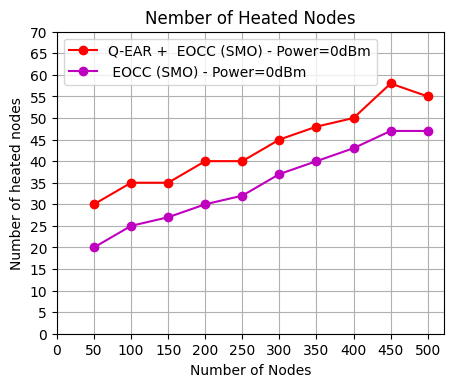

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_H = df_sensor_power.loc[df_sensor_power[:] ==0]
sensor_power_cache_1=temp_cache_2(df_sensor_L[:, :, 50])
sensor_power_cache_2=temp_cache_2(df_sensor_L[:, :, 100])
sensor_power_cache_3=temp_cache_2(df_sensor_L[:, :, 150])
sensor_power_cache_4=temp_cache_2(df_sensor_L[:, :, 200])
sensor_power_cache_5=temp_cache_2(df_sensor_L[:, :, 250])
sensor_power_cache_6=temp_cache_2(df_sensor_L[:, :, 300])
sensor_power_cache_7=temp_cache_2(df_sensor_L[:, :, 350])
sensor_power_cache_8=temp_cache_2(df_sensor_L[:, :, 400])
sensor_power_cache_9=temp_cache_2(df_sensor_L[:, :, 450])
sensor_power_cache_10=temp_cache_2(df_sensor_L[:, :, 500])
xpoints_L= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_L= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_L,ypoints_L, 'r-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_H = df_sensor_power.loc[df_sensor_power[:] ==0]
sensor_power_cache_1=temp_cache(df_sensor_L[:,10, :])
sensor_power_cache_2=temp_cache(df_sensor_L[:,20, :])
sensor_power_cache_3=temp_cache(df_sensor_L[:,30, :])
sensor_power_cache_4=temp_cache(df_sensor_L[:,40, :])
sensor_power_cache_5=temp_cache(df_sensor_L[:,50, :])
sensor_power_cache_6=temp_cache(df_sensor_L[:,60, :])
sensor_power_cache_7=temp_cache(df_sensor_L[:,70, :])
sensor_power_cache_8=temp_cache(df_sensor_L[:,80, :])
sensor_power_cache_9=temp_cache(df_sensor_L[:,90, :])
sensor_power_cache_10=temp_cache(df_sensor_L[:,100, :])
xpoints_L= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_L= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_L,ypoints_L, 'm-o')
plt.yticks([0,5,10,15,20,25,30,35,40,45, 50,55,60,65,70])
plt.xticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of Nodes')
plt.ylabel('Number of heated nodes')
plt.title("Nember of Heated Nodes")
plt.legend(['Q-EAR +  EOCC (SMO) - Power=0dBm', ' EOCC (SMO) - Power=0dBm'])
plt.grid(True)


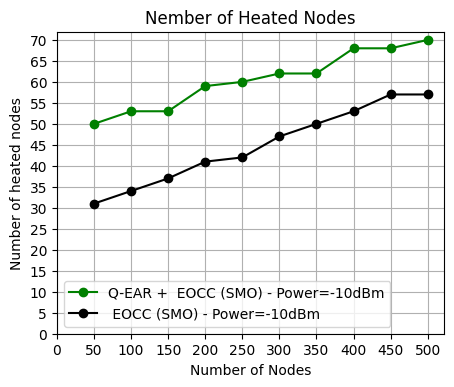

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-10]
sensor_power_cache_1=temp_cache_2(df_sensor_H[:, :, 50])
sensor_power_cache_2=temp_cache_2(df_sensor_H[:, :, 100])
sensor_power_cache_3=temp_cache_2(df_sensor_H[:, :, 150])
sensor_power_cache_4=temp_cache_2(df_sensor_H[:, :, 200])
sensor_power_cache_5=temp_cache_2(df_sensor_H[:, :, 250])
sensor_power_cache_6=temp_cache_2(df_sensor_H[:, :, 300])
sensor_power_cache_7=temp_cache_2(df_sensor_H[:, :, 350])
sensor_power_cache_8=temp_cache_2(df_sensor_H[:, :, 400])
sensor_power_cache_9=temp_cache_2(df_sensor_H[:, :, 450])
sensor_power_cache_10=temp_cache_2(df_sensor_H[:, :, 500])
xpoints_H = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_H = [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_H,ypoints_H, 'g-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-10]
sensor_power_cache_1=temp_cache(df_sensor_H[:, :, 50])
sensor_power_cache_2=temp_cache(df_sensor_H[:, :, 100])
sensor_power_cache_3=temp_cache(df_sensor_H[:, :, 150])
sensor_power_cache_4=temp_cache(df_sensor_H[:, :, 200])
sensor_power_cache_5=temp_cache(df_sensor_H[:, :, 250])
sensor_power_cache_6=temp_cache(df_sensor_H[:, :, 300])
sensor_power_cache_7=temp_cache(df_sensor_H[:, :, 350])
sensor_power_cache_8=temp_cache(df_sensor_H[:, :, 400])
sensor_power_cache_9=temp_cache(df_sensor_H[:, :, 450])
sensor_power_cache_10=temp_cache(df_sensor_H[:, :, 500])
xpoints_H = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_H = [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_H,ypoints_H, 'k-o')
plt.yticks([0,5,10,15,20,25,30,35,40,45, 50,55,60,65,70])
plt.xticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of Nodes')
plt.ylabel('Number of heated nodes')
plt.title("Nember of Heated Nodes")
plt.legend(['Q-EAR +  EOCC (SMO) - Power=-10dBm', ' EOCC (SMO) - Power=-10dBm'])
plt.grid(True)

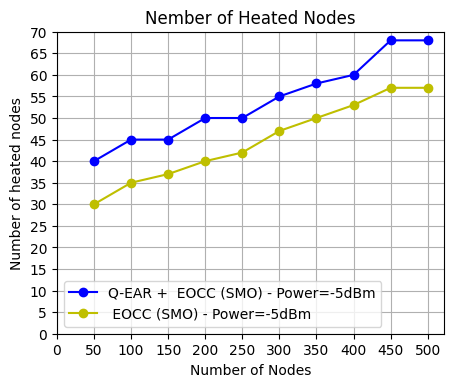

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_L = df_sensor_power.loc[df_sensor_power[:] ==-5]
sensor_power_cache_1=temp_cache_2(df_sensor_M[:, :, 50])
sensor_power_cache_2=temp_cache_2(df_sensor_M[:, :, 100])
sensor_power_cache_3=temp_cache_2(df_sensor_M[:, :, 150])
sensor_power_cache_4=temp_cache_2(df_sensor_M[:, :, 200])
sensor_power_cache_5=temp_cache_2(df_sensor_M[:, :, 250])
sensor_power_cache_6=temp_cache_2(df_sensor_M[:, :, 300])
sensor_power_cache_7=temp_cache_2(df_sensor_M[:, :, 350])
sensor_power_cache_8=temp_cache_2(df_sensor_M[:, :, 400])
sensor_power_cache_9=temp_cache_2(df_sensor_M[:, :, 450])
sensor_power_cache_10=temp_cache_2(df_sensor_M[:, :, 500])
xpoints_M= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_M= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_M,ypoints_M, 'b-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-5]
sensor_power_cache_1=temp_cache(df_sensor_M[:, :, 50])
sensor_power_cache_2=temp_cache(df_sensor_M[:, :, 100])
sensor_power_cache_3=temp_cache(df_sensor_M[:, :, 150])
sensor_power_cache_4=temp_cache(df_sensor_M[:, :, 200])
sensor_power_cache_5=temp_cache(df_sensor_M[:, :, 250])
sensor_power_cache_6=temp_cache(df_sensor_M[:, :, 300])
sensor_power_cache_7=temp_cache(df_sensor_M[:, :, 350])
sensor_power_cache_8=temp_cache(df_sensor_M[:, :, 400])
sensor_power_cache_9=temp_cache(df_sensor_M[:, :, 450])
sensor_power_cache_10=temp_cache(df_sensor_M[:, :, 500])
xpoints_M= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_M= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_M,ypoints_M, 'y-o')
plt.yticks([0,5,10,15,20,25,30,35,40,45, 50,55,60,65,70])
plt.xticks([0,50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Number of Nodes')
plt.ylabel('Number of heated nodes')
plt.title("Nember of Heated Nodes")
plt.legend(['Q-EAR +  EOCC (SMO) - Power=-5dBm', ' EOCC (SMO) - Power=-5dBm'])
plt.grid(True)

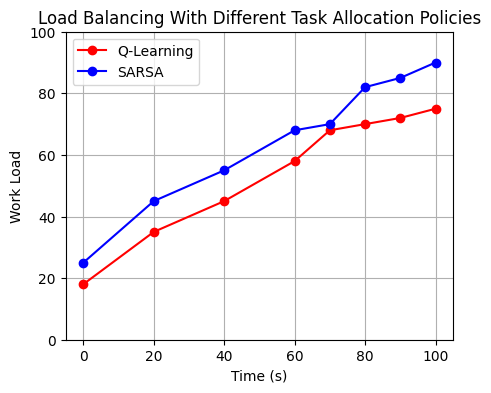

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)

xpoints_M= [0,20, 40, 60, 70, 80 , 90, 100]
ypoints_M= [18,35,45, 58, 68, 70, 72, 75]
plt.plot(xpoints_M,ypoints_M, 'r-o')

xpoints_M= [0,20, 40, 60, 70, 80 , 90, 100]
ypoints_M= [25,45,55, 68, 70, 82, 85, 90]
plt.plot(xpoints_M,ypoints_M, 'b-o')
plt.xticks([0, 20 ,40, 60, 80, 100])
plt.yticks([0, 20, 40 ,60, 80 ,100])
plt.xlabel('Time (s)')
plt.ylabel('Work Load')
plt.title("Load Balancing With Different Task Allocation Policies")
plt.legend(['Q-Learning', 'SARSA'])
plt.grid(True)

#Packet by power

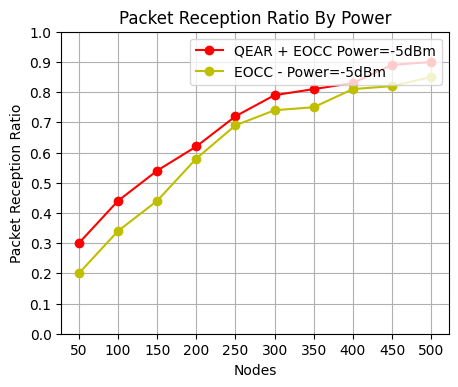

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-5]
sensor_power_cache_1=throughput_cache_2(df_sensor_M[:, :, 50])
sensor_power_cache_2=throughput_cache_2(df_sensor_M[:, :, 100])
sensor_power_cache_3=throughput_cache_2(df_sensor_M[:, :, 150])
sensor_power_cache_4=throughput_cache_2(df_sensor_M[:, :, 200])
sensor_power_cache_5=throughput_cache_2(df_sensor_M[:, :, 250])
sensor_power_cache_6=throughput_cache_2(df_sensor_M[:, :, 300])
sensor_power_cache_7=throughput_cache_2(df_sensor_M[:, :, 350])
sensor_power_cache_8=throughput_cache_2(df_sensor_M[:, :, 400])
sensor_power_cache_9=throughput_cache_2(df_sensor_M[:, :, 450])
sensor_power_cache_10=throughput_cache_2(df_sensor_M[:, :, 500])
xpoints_M= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_M= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_M,ypoints_M, 'r-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-5]
sensor_power_cache_1=throughput_cache(df_sensor_M[:, :, 50])
sensor_power_cache_2=throughput_cache(df_sensor_M[:, :, 100])
sensor_power_cache_3=throughput_cache(df_sensor_M[:, :, 150])
sensor_power_cache_4=throughput_cache(df_sensor_M[:, :, 200])
sensor_power_cache_5=throughput_cache(df_sensor_M[:, :, 250])
sensor_power_cache_6=throughput_cache(df_sensor_M[:, :, 300])
sensor_power_cache_7=throughput_cache(df_sensor_M[:, :, 350])
sensor_power_cache_8=throughput_cache(df_sensor_M[:, :, 400])
sensor_power_cache_9=throughput_cache(df_sensor_M[:, :, 450])
sensor_power_cache_10=throughput_cach(df_sensor_M[:, :, 500])
xpoints_M= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_M= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,sensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_M,ypoints_M, 'Y-o')
plt.yticks([0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Nodes')
plt.ylabel('Packet Reception Ratio')
plt.title("Packet Reception Ratio By Power")
plt.legend(['QEAR + EOCC Power=-5dBm', 'EOCC - Power=-5dBm'], loc='upper right')
plt.grid(True)

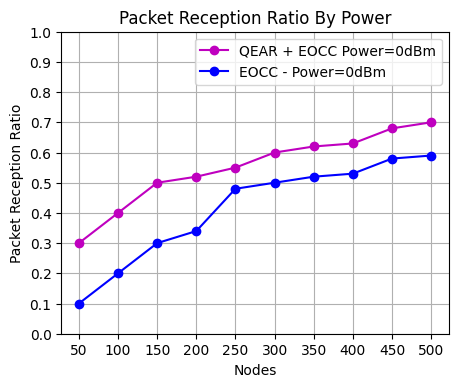

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_H = df_sensor_power.loc[df_sensor_power[:] ==0]
sensor_power_cache_1=throughput_cache_2(df_sensor_L[:, :, 50])
sensor_power_cache_2=throughput_cache_2(df_sensor_L[:, :, 100])
sensor_power_cache_3=throughput_cache_2(df_sensor_L[:, :, 150])
sensor_power_cache_4=throughput_cache_2(df_sensor_L[:, :, 200])
sensor_power_cache_5=throughput_cache_2(df_sensor_L[:, :, 250])
sensor_power_cache_6=throughput_cache_2(df_sensor_L[:, :, 300])
sensor_power_cache_7=throughput_cache_2(df_sensor_L[:, :, 350])
sensor_power_cache_8=throughput_cache_2(df_sensor_L[:, :, 400])
sensor_power_cache_9=throughput_cache_2(df_sensor_L[:, :, 450])
sensor_power_cache_10=throughput_cache_2(df_sensor_L[:, :, 500])
xpoints_L= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_L= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,ensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_L,ypoints_L, 'b-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_H = df_sensor_power.loc[df_sensor_power[:] ==0]
sensor_power_cache_1=throughput_cache(df_sensor_L[:, :, 50])
sensor_power_cache_2=throughput_cache(df_sensor_L[:, :, 100])
sensor_power_cache_3=throughput_cache(df_sensor_L[:, :, 150])
sensor_power_cache_4=throughput_cache(df_sensor_L[:, :, 200])
sensor_power_cache_5=throughput_cache(df_sensor_L[:, :, 250])
sensor_power_cache_6=throughput_cache(df_sensor_L[:, :, 300])
sensor_power_cache_7=throughput_cache(df_sensor_L[:, :, 350])
sensor_power_cache_8=throughput_cache(df_sensor_L[:, :, 400])
sensor_power_cache_9=throughput_cache(df_sensor_L[:, :, 450])
sensor_power_cache_10=throughput_cache(df_sensor_L[:, :, 500])
xpoints_L= [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_L= [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,ensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_L,ypoints_L, 'm-o')
plt.yticks([0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Nodes')
plt.ylabel('Packet Reception Ratio')
plt.title("Packet Reception Ratio By Power")
plt.legend(['QEAR + EOCC Power=0dBm', 'EOCC - Power=0dBm'], loc='upper right')
plt.grid(True)

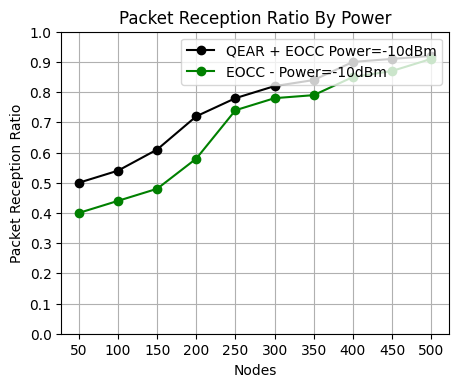

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
df_sensor_power = power_cache_2[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-10]
sensor_power_cache_1=throughput_cache_2(df_sensor_H[:, :, 50])
sensor_power_cache_2=throughput_cache_2(df_sensor_H[:, :, 100])
sensor_power_cache_3=throughput_cache_2(df_sensor_H[:, :, 150])
sensor_power_cache_4=throughput_cache_2(df_sensor_H[:, :, 200])
sensor_power_cache_5=throughput_cache_2(df_sensor_H[:, :, 250])
sensor_power_cache_6=throughput_cache_2(df_sensor_H[:, :, 300])
sensor_power_cache_7=throughput_cache_2(df_sensor_H[:, :, 350])
sensor_power_cache_8=throughput_cache_2(df_sensor_H[:, :, 400])
sensor_power_cache_9=throughput_cache_2(df_sensor_H[:, :, 450])
sensor_power_cache_10=throughput_cache_2(df_sensor_H[:, :, 500])
xpoints_H = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_H = [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,ensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_H,ypoints_H, 'g-o')
df_sensor_power = power_cache[:,:,:]
df_sensor_M = df_sensor_power.loc[df_sensor_power[:] ==-10]
sensor_power_cache_1=throughput_cache(df_sensor_H[:, :, 50])
sensor_power_cache_2=throughput_cache(df_sensor_H[:, :, 100])
sensor_power_cache_3=throughput_cache(df_sensor_H[:, :, 150])
sensor_power_cache_4=throughput_cache(df_sensor_H[:, :, 200])
sensor_power_cache_5=throughput_cache(df_sensor_H[:, :, 250])
sensor_power_cache_6=throughput_cache(df_sensor_H[:, :, 300])
sensor_power_cache_7=throughput_cache(df_sensor_H[:, :, 350])
sensor_power_cache_8=throughput_cache(df_sensor_H[:, :, 400])
sensor_power_cache_9=throughput_cache(df_sensor_H[:, :, 450])
sensor_power_cache_10=throughput_cache(df_sensor_H[:, :, 500])
xpoints_H = [50, 100, 150,  200, 250, 300, 350, 400, 450, 500]
ypoints_H = [sensor_power_cache_1,sensor_power_cache_2 ,sensor_power_cache_3 ,sensor_power_cache_4 ,sensor_power_cache_5 ,sensor_power_cache_6 ,sensor_power_cache_7 ,sensor_power_cache_8 ,ensor_power_cache_9 ,sensor_power_cache_10]
plt.plot(xpoints_H,ypoints_H, 'K-o')
plt.yticks([0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xticks([50, 100, 150,  200, 250, 300, 350, 400, 450, 500])
plt.xlabel('Nodes')
plt.ylabel('Packet Reception Ratio')
plt.title("Packet Reception Ratio By Power")
plt.legend(['QEAR + EOCC Power=-10dBm', 'EOCC - Power=-10dBm'], loc='upper right')
plt.grid(True)

#**Tier 2**

#**Rayleigh Fading Channel**

کانال‌های محو ریلی مدل‌های مفیدی از پدیده‌های دنیای واقعی در ارتباطات بی‌سیم هستند. این پدیده ها شامل اثرات پراکندگی چند مسیری، پراکندگی زمانی و جابجایی های داپلر است که از حرکت نسبی بین فرستنده و گیرنده ناشی می شود.
 شکل زیر منعکس شده مستقیم و اصلی بین یک فرستنده رادیویی ثابت و یک گیرنده متحرک را نشان می دهد. اشکال سایه دار بازتاب دهنده هایی مانند ساختمان ها هستند.



#**NOMA - Rayleigh Flat Fading Channel**

##**Random Walk**

In [ ]:
!pip install pyrandwalk

#**Random Walk**

In [ ]:
!pip install pyrandwalk

     |████████████████████████████████| 590 kB 4.2 MB/s 


In [ ]:
!pip install sdeint

In [ ]:
def db2pow(xdb):
    """Convert decibels (dB) to power

    .. doctest::

        >>> from spectrum import db2pow
        >>> p = db2pow(-10)
        >>> p
        0.1

    .. seealso:: :func:`pow2db`
    """
    return 10.**(xdb/10.)

#**Q Learning Rayleigh Flat Fading Quasi Static - NOMA**

In [ ]:
import numpy as np
from time import sleep
from datetime import datetime
import time
from random import randrange
import random
import multiprocessing
training_qlearn()
import matplotlib.pyplot as plt
import numpy as np
import math
from pyrandwalk import *
from scipy.spatial import distance
v_mph = 60 # velocity
center_freq = 200e6 # RF carrier frequency in Hz
Fs = 1e5 # sample rate of simulation
N = 100# number of patients 100
K=13 #Access Points=13
transmit_cnt=10000
totPower=1 #%Total power of LOS path & scattered paths
Ps=1
AAS_thereshold=0.000002
v = v_mph * 0.44704 # convert to m/s
fd = v*center_freq/3e8 # max
#print("max Doppler shift:", fd)
t = np.arange(0, 1, 1/Fs) # time vector. (start, stop, step)
x = np.zeros(len(t))
y = np.zeros(len(t))
EbN0dB = [0, 10, 40]
count_num=transmit_cnt
patient_num=N
aps = K
energy_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
packet_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
throughput_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
time_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
elapsed_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
patients_priority_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
sensors_dead_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
power_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
velocity_cache = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
shortest_path = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
r_hat=0.5
states = [0, 1, 2, 3, 4]
transition = np.array([[1,    0, 0,    0, 0],
                   [0.25, 0, 0.75, 0, 0],
                   [0, 0.25, 0, 0.75, 0],
                   [0, 0, 0.25, 0, 0.75],
                   [0, 0,    0, 1,    0]])
E = 100
Erx_elec = 36.1*0.000000001
Etx_elec = 16.7*0.000000001
Eamp = 1.97*0.000000001
k=8
elapsed_hub=1

time_now = datetime.now()
elapsed = 0
sleep=0.005
from scipy import special as sp
def q_func(x):
  return 0.5-0.5*sp.erf(x/np.sqrt(2))
#RandomWalk
rw = RandomWalk(states, transition)
states, probs = rw.run()
rw_v = max(probs)
for i in range(transmit_cnt):
  for j in range(N):
    for ap in range(K):
      #1. compute fading channel coefficient related to the symbol transmission from Hi is represented by LHi
      Ml=40 #db
      L1=30 #reference distance= 1m =30 db
      N0=1.2 #power
      euclidean_distance__ha = 0 # Euclidean Distance between hub and access points
      n_power=4
      #2. compute Rayleigh distributed with probability density function (pdf)
      phi=np.pi/2
      theta = np.linspace(-np.pi, np.pi, 6000)
      ohm = (1/(2*np.pi))* np.exp(- j) * (1 + (np.sqrt(4*np.pi*j) \
            * np.exp(j * (np.cos(theta-phi))**2) *np.cos(theta-phi)) \
            * (1 - q_func(np.sqrt(2*j) * np.cos(theta-phi))))

      ohm=ohm**2
      r = np.linspace(0, 6, 6000)
      LHc = ((2*r)/ohm)*np.exp(-r**2/ohm)
      # 3. compute path loss between hub_i and access_points_j  محاسبه مسیر های از دست رفته بین هاب و آنتن ها
      # 4. LHc -> Rayleigh distributed with probability density function (pdf)  محاسبه تابع احتمال چگالی توزیع رایلی
      alpha = (np.random.rand() - 0.5) * 2 * np.pi
      phi =   (np.random.rand() - 0.5) * 2 * np.pi
      p=phi
      x = x + np.random.randn() * np.cos(2 * np.pi * fd * t * np.cos(alpha) + phi)
      y = y + np.random.randn() * np.sin(2 * np.pi * fd * t * np.cos(alpha) + phi)
      xx=int(abs(sum(x)))
      num_str_x = str(xx)
      x_digit = num_str_x[0]
      phi=int(x_digit)
      yy=int(abs(sum(y)))
      num_str_y = str(yy)
      y_digit = num_str_y[0]
      Ghq=int(y_digit)
      # 5. Compute Euclidean Distance between hub and access points  محاسبه فاصله اقلیدسی بین هاب و آنتن ها
      euclidean_distance__ha = distance.euclidean(x, y)

      # 6. Noise samples (AWGN) with zero mean and unit variance
      noise = (np.random.randn(1,20)+np.random.randn(1,20))/math.sqrt(2) #AWGN with unity power
      Phq=int(y_digit)
      L_d=Ml*(euclidean_distance__ha**n_power)*L1
      GHi=sum(LHc/np.sqrt(L_d))

      #7. Compute SINR = Signal-to-Interference plus Noise Ratio (SINR) محاسبه سیگنالهای تداخلی بعلاوه نرخ نویزها با مجذور خی
      #8. Chi-square distributed γ with 2 degrees of freedom and with the pdf
      Ghq = rw_v**2
      SINR = (GHi**2)*int(x_digit)/ N0+Ghq**2*Phq
      SNR = (ohm/L_d) * (phi/N0)

      # 9. Compute Edge Server Adaptive Access Point Selection
      Tem=1
      Eh = (Erx_elec+Eamp)*euclidean_distance__ha**n_power*L1
      if max(SNR)<SINR:
        AAS = (SINR*Tem)/(Eh*phi)
        Bhi=(Tem/Phq)
        # 10. Received Signal at Access Point
        if AAS>AAS_thereshold:
          Xsignal_receiver=(GHi*Bhi*Ps)*int(x_digit)+noise
          Rayleigh_Flat_Fading=[]
          for sig in Xsignal_receiver:
            Rayleigh_Flat_Fading.append(sig)
          Rayleigh_Flat_Fading = sum(Rayleigh_Flat_Fading)
          Rayleigh_Flat_Fading=int(abs(sum(Rayleigh_Flat_Fading)))
          Rayleigh_Flat_Fading = str(Rayleigh_Flat_Fading)
          Rayleigh_Flat_Fading = Rayleigh_Flat_Fading[0]
          d=math.sqrt(((int(Rayleigh_Flat_Fading))**2)+((int(y_digit))**2))
          Ekd    = Erx_elec*k* d**2 +  Etx_elec*k + Eamp *k *d**2
          Ekd    = round(Ekd, 10)
          time.sleep(sleep) #sleeps for x seconds
          status='sleeping...'
          if status=='sleeping...':
            elapsed_timecache =   elapsed_hub*(sleep*10**6)-2
          else:
            # 11. Computing while sensor is not in resting or sleeping mode
            energy_cache[i, j, ap] = energy_cache[j - 1, i]  - Ekd #K - N
            time_cache[i, j, ap] = (time_now.minute*60+time_now.second)+elapsed_timecache
            packet_cache[i, j, ap] = packet_cache[j, i] + 1 #K - N
            shortest_path[i, j, ap]=get_shortest_path_NOMA(int(Rayleigh_Flat_Fading), int(y_digit))
            velocity_cache[i, j, ap] = int(shortest_path[i, j, ap])/int(time_cache[i, j, ap])
            throughput_cache[i, j, ap]=throughput_cache[j-1, i]+packet_cache[j, i]

#**Episodes - Learning Rate**

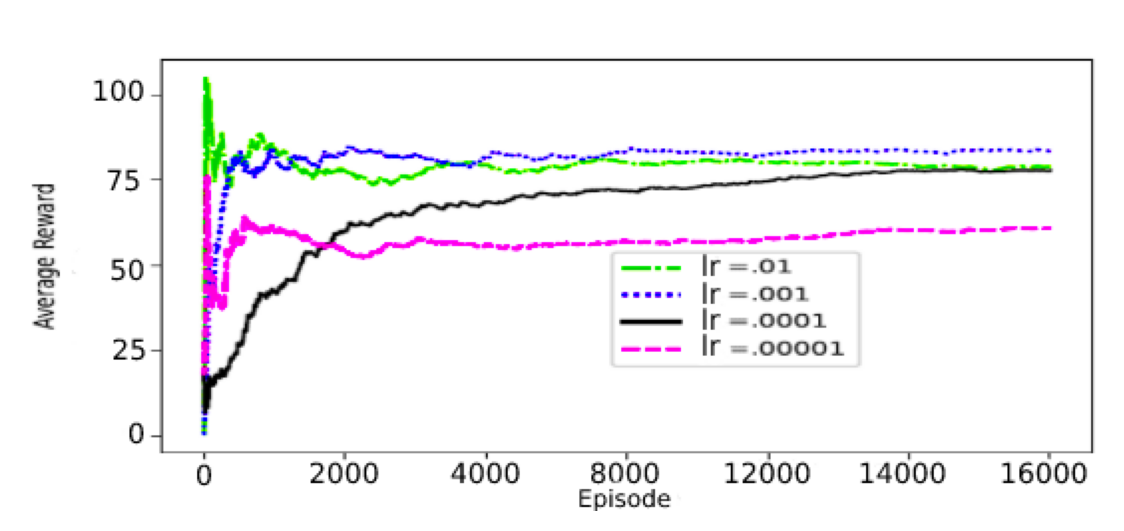

In [ ]:
import matplotlib.pyplot as plt
sensor_rewards_1 =rewards[0:1000, :, :].mean()
sensor_rewards_2 =rewards[0:2000, :, :].mean()
sensor_rewards_3 =rewards[0:3000, :, :].mean()
sensor_rewards_4 =rewards[0:4000, :, :].mean()
sensor_rewards_5 =rewards[0:5000, :, :].mean()
sensor_rewards_6 =rewards[0:6000, :, :].mean()
sensor_rewards_7 =rewards[0:7000, :, :].mean()
sensor_rewards_8 =rewards[0:8000, :, :].mean()
sensor_rewards_9 =rewards[0:9000, :, :].mean()
sensor_rewards_10=rewards[0:10000, :, :].mean()
sensor_rewards_12=rewards[0:12000, :, :].mean()
sensor_rewards_14=rewards[0:14000, :, :].mean()
sensor_rewards_16=rewards[0:16000, :, :].mean()
xpoints_eeg = [0, 0 ,0, 0, 1,5 ,20, 30 ,300,500, 800,  1000,1500 ,2000,2500,3000,  4000,  6000, 8000, 10000, 12000, 14000, 16000]
ypoints_episode =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_12,sensor_temp_cache_14,sensor_temp_cache_16]
plt.plot(xpoints_eeg, ypoints_eeg,  lw=1, marker='_', color='g', ms=4)
xpoints_eeg = [0, 0 ,0, 0, 1,5 ,20, 30 ,300,500, 800,  1000,1500 ,2000,2500,3000,  4000,  6000, 8000, 10000, 12000, 14000, 16000]
ypoints_episode =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_12,sensor_temp_cache_14,sensor_temp_cache_16]
plt.plot(xpoints_eeg, ypoints_eeg,  lw=1, marker='_', color='m', ms=4)
xpoints_eeg = [0, 0 ,0, 0, 1,5 ,20, 30 ,300,500, 800,  1000,1500 ,2000,2500,3000,  4000,  6000, 8000, 10000, 12000, 14000, 16000]
ypoints_episode =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_12,sensor_temp_cache_14,sensor_temp_cache_16]
plt.plot(xpoints_eeg, ypoints_eeg,  lw=1, marker='_', color='k', ms=4)
xpoints_eeg = [0, 0 ,0, 0, 1,5 ,20, 30 ,300,500, 800,  1000,1500 ,2000,2500,3000,  4000,  6000, 8000, 10000, 12000, 14000, 16000]
ypoints_episode =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_12,sensor_temp_cache_14,sensor_temp_cache_16]
plt.plot(xpoints_eeg, ypoints_eeg,  lw=1, marker='_', color='r', ms=4)
plt.yticks([0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xticks([0, 2000, 4000,  6000, 8000, 10000, 12000, 14000, 16000])
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend(['lr=.01', 'lr=.001', 'lr=.0001', 'lr=.00001'])
plt.show()

#**Cumulative Rewards**

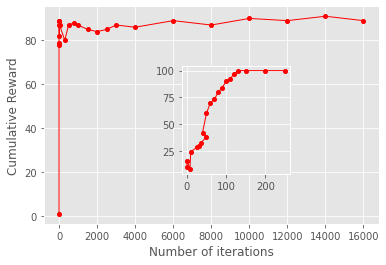

In [ ]:
import matplotlib.pyplot as plt
from random import randrange
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ypoints_eeg2=[]
for i in range(10000):
    ypoints_eeg2.append(randrange(10000))
sensor_rewards_1 =rewards[0:1000, :, :].mean()
sensor_rewards_2 =rewards[0:2000, :, :].mean()
sensor_rewards_3 =rewards[0:3000, :, :].mean()
sensor_rewards_4 =rewards[0:4000, :, :].mean()
sensor_rewards_5 =rewards[0:5000, :, :].mean()
sensor_rewards_6 =rewards[0:6000, :, :].mean()
sensor_rewards_7 =rewards[0:7000, :, :].mean()
sensor_rewards_8 =rewards[0:8000, :, :].mean()
sensor_rewards_9 =rewards[0:9000, :, :].mean()
sensor_rewards_10=rewards[0:10000, :, :].mean()
sensor_rewards_12=rewards[0:12000, :, :].mean()
sensor_rewards_14=rewards[0:14000, :, :].mean()
sensor_rewards_16=rewards[0:16000, :, :].mean()
x = [0, 0 ,0, 0, 1,5 ,20, 30 ,300,500, 800,  1000,1500 ,2000,2500,3000,  4000,  6000, 8000, 10000, 12000, 14000, 16000]
y =[sensor_temp_cache_1 ,sensor_temp_cache_2 ,sensor_temp_cache_3 ,sensor_temp_cache_4 ,sensor_temp_cache_5 ,sensor_temp_cache_6 ,sensor_temp_cache_7 ,sensor_temp_cache_8 ,sensor_temp_cache_9 ,sensor_temp_cache_10,sensor_temp_cache_12,sensor_temp_cache_14,sensor_temp_cache_16]
ax.plot(x,y,  lw=1, marker='o', color='r', ms=4) # square # this is the main plot
plt.xlabel('Number of iterations')
plt.ylabel('Cumulative Reward')
#this is the small figure
ins_ax = inset_axes(ax, width=1.5, height=1.5,
          bbox_transform=ax.transAxes, bbox_to_anchor=(0.75,0.75),)

# the small plot just by slicing the original data
ins_ax.plot(x[0:300],  lw=1, marker='o', color='r', ms=4)
plt.show()
plt.yticks([0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.xticks([0, 2000, 4000,  6000, 8000, 10000, 12000, 14000, 16000])
plt.xlabel('Number of iterations')
plt.ylabel('Average Reward')
plt.show()

#**MPDS - Rayleigh Flat Fading Quasi Static - NOMA**

In [ ]:
import numpy as np
from time import sleep
from datetime import datetime
import time
from random import randrange
import random
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
import math
import math
from pyrandwalk import *
from scipy.spatial import distance
v_mph = 60 # velocity
center_freq = 200e6 # RF carrier frequency in Hz
Fs = 1e5 # sample rate of simulation
N = 100# number of patients 100
K=13 #Access Points=13
transmit_cnt=10000
totPower=1 #%Total power of LOS path & scattered paths
Ps=1
AAS_thereshold=0.000002
v = v_mph * 0.44704 # convert to m/s
fd = v*center_freq/3e8 # max
#print("max Doppler shift:", fd)
t = np.arange(0, 1, 1/Fs) # time vector. (start, stop, step)
x = np.zeros(len(t))
y = np.zeros(len(t))
EbN0dB = [0, 10, 40]
count_num=transmit_cnt
patient_num=N
aps = K
energy_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
packet_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
throughput_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
time_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
elapsed_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
patients_priority_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
sensors_dead_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
power_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
velocity_cache_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
shortest_path_2 = np.zeros((count_num, patient_num, aps),  dtype=object) #Count - Patient - Sensor
r_hat=0.5
states = [0, 1, 2, 3, 4]
transition = np.array([[1,    0, 0,    0, 0],
                   [0.25, 0, 0.75, 0, 0],
                   [0, 0.25, 0, 0.75, 0],
                   [0, 0, 0.25, 0, 0.75],
                   [0, 0,    0, 1,    0]])
E = 2
Erx_elec = 50*0.000000001
Etx_elec = 16.7*0.000000001
Eamp = 0.1*0.000000001
Rs=2
Rh=230
dist=math.sqrt(Rh-Rs)**2
k=8
elapsed_hub=1
time_now = datetime.now()
elapsed = 0
sleep=0.005
from scipy import special as sp
def q_func(x):
  return 0.5-0.5*sp.erf(x/np.sqrt(2))
#RandomWalk
rw = RandomWalk(states, transition)
states, probs = rw.run()
rw_v = max(probs)
for i in range(transmit_cnt):
  for j in range(N):
    for ap in range(K):
      #1. compute fading channel coefficient related to the symbol transmission from Hi is represented by LHi
      Ml=40 #db
      L1=30 #reference distance= 1m =30 db
      N0=1.2 #power
      euclidean_distance__ha = 0 # Euclidean Distance between hub and access points
      n_power=4
      #2. compute Rayleigh distributed with probability density function (pdf)
      phi=np.pi/2
      theta = np.linspace(-np.pi, np.pi, 6000)
      ohm = (1/(2*np.pi))* np.exp(- j) * (1 + (np.sqrt(4*np.pi*j) \
            * np.exp(j * (np.cos(theta-phi))**2) *np.cos(theta-phi)) \
            * (1 - q_func(np.sqrt(2*j) * np.cos(theta-phi))))

      ohm=ohm**2
      r = np.linspace(0, 6, 6000)
      LHc = ((2*r)/ohm)*np.exp(-r**2/ohm)
      # 3. compute path loss between hub_i and access_points_j  محاسبه مسیر های از دست رفته بین هاب و آنتن ها
      # 4. LHc -> Rayleigh distributed with probability density function (pdf)  محاسبه تابع احتمال چگالی توزیع رایلی
      alpha = (np.random.rand() - 0.5) * 2 * np.pi
      phi =   (np.random.rand() - 0.5) * 2 * np.pi
      p=phi
      x = x + np.random.randn() * np.cos(2 * np.pi * fd * t * np.cos(alpha) + phi)
      y = y + np.random.randn() * np.sin(2 * np.pi * fd * t * np.cos(alpha) + phi)
      xx=int(abs(sum(x)))
      num_str_x = str(xx)
      x_digit = num_str_x[0]
      phi=int(x_digit)
      yy=int(abs(sum(y)))
      num_str_y = str(yy)
      y_digit = num_str_y[0]
      Ghq=int(y_digit)
      # 5. Compute Euclidean Distance between hub and access points  محاسبه فاصله اقلیدسی بین هاب و آنتن ها
      euclidean_distance__ha = distance.euclidean(x, y)

      # 6. Noise samples (AWGN) with zero mean and unit variance
      noise = (np.random.randn(1,20)+np.random.randn(1,20))/math.sqrt(2) #AWGN with unity power
      Phq=int(y_digit)
      L_d=Ml*(euclidean_distance__ha**n_power)*L1
      GHi=sum(LHc/np.sqrt(L_d))

      #7. Compute SINR = Signal-to-Interference plus Noise Ratio (SINR) محاسبه سیگنالهای تداخلی بعلاوه نرخ نویزها با مجذور خی
      #8. Chi-square distributed γ with 2 degrees of freedom and with the pdf
      Ghq = rw_v**2
      SINR = (GHi**2)*int(x_digit)/ N0+Ghq**2*Phq
      SNR = (ohm/L_d) * (phi/N0)

      # 9. Compute Edge Server Adaptive Access Point Selection
      Tem=1
      Eh = (Erx_elec+Eamp)*euclidean_distance__ha**n_power*L1
      if max(SNR)<SINR:
        AAS = (SINR*Tem)/(Eh*phi)
        Bhi=(Tem/Phq)
        # 10. Received Signal at Access Point
        if AAS>AAS_thereshold:
          Xsignal_receiver=(GHi*Bhi*Ps)*int(x_digit)+noise
          Rayleigh_Flat_Fading=[]
          for sig in Xsignal_receiver:
            Rayleigh_Flat_Fading.append(sig)
          Rayleigh_Flat_Fading = sum(Rayleigh_Flat_Fading)
          Rayleigh_Flat_Fading=int(abs(sum(Rayleigh_Flat_Fading)))
          Rayleigh_Flat_Fading = str(Rayleigh_Flat_Fading)
          Rayleigh_Flat_Fading = Rayleigh_Flat_Fading[0]
          d=math.sqrt(((int(Rayleigh_Flat_Fading))**2)+((int(y_digit))**2))
          Ekd    = Erx_elec*k* d**2 +  Etx_elec*k + Eamp *k *d**2
          Ekd    = round(Ekd, 10)
          time.sleep(sleep) #sleeps for x seconds
          status='sleeping...'
          if status=='sleeping...':
            elapsed_timecache =   elapsed_hub*(sleep*10**6)-2
          else:
            # 11. Computing while sensor is not in resting or sleeping mode
            energy_cache[i, j, ap] = energy_cache[j - 1, i]  - Ekd #K - N
            time_cache[i, j, ap] = (time_now.minute*60+time_now.second)+elapsed_timecache
            packet_cache[i, j, ap] = packet_cache[j, i] + 1 #K - N
            shortest_path[i, j, ap]=math.sqrt(int(Rayleigh_Flat_Fading)- int(y_digit))**2 +dist
            velocity_cache[i, j, ap] = int(shortest_path[i, j, ap])/int(time_cache[i, j, ap])
            throughput_cache[i, j, ap]=throughput_cache[j-1, i]+packet_cache[j, i]

#**MPDS - Average Delay - Number of Patients - NOMA - Rayleigh**

#**Average Delay - Number of Patients - NOMA - Rayleigh**

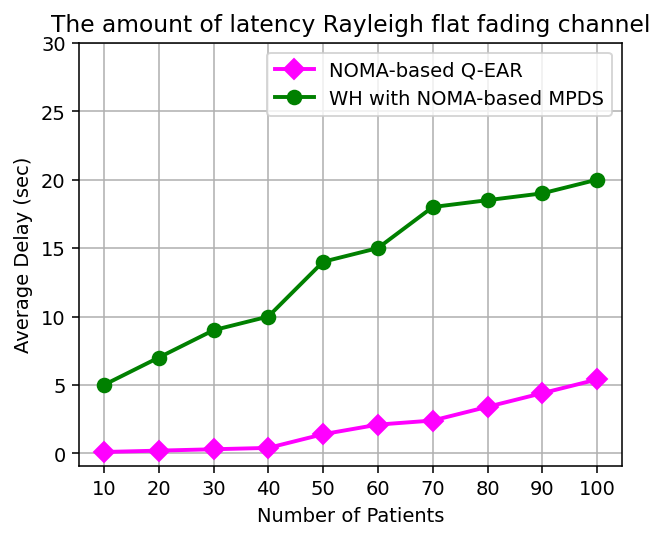

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_time_cache_1 =time_cache[:,10,:].mean()
sensor_time_cache_2 =time_cache[:,20,:].mean()
sensor_time_cache_3 =time_cache[:,30,:].mean()
sensor_time_cache_4 =time_cache[:,40,:].mean()
sensor_time_cache_5 =time_cache[:,50,:].mean()
sensor_time_cache_6 =time_cache[:,60,:].mean()
sensor_time_cache_7 =time_cache[:,70,:].mean()
sensor_time_cache_8 =time_cache[:,80,:].mean()
sensor_time_cache_9 =time_cache[:,90,:].mean()
sensor_time_cache_10=time_cache[:,100,:].mean()
xpoints_endtoend=[10, 20, 30,  40, 50, 60, 70, 80, 90, 100]
ypoints_endtoend = [sensor_time_cache_1 ,sensor_time_cache_2 ,sensor_time_cache_3 ,sensor_time_cache_4 ,sensor_time_cache_5 ,sensor_time_cache_6 ,sensor_time_cache_7 ,sensor_time_cache_8 ,sensor_time_cache_9 ,sensor_time_cache_10]
plt.plot(xpoints_endtoend,ypoints_endtoend, label = 'NOMA-based Q-EAR+EOCC',color='magenta', lw=2,markerfacecolor='magenta',marker='D', ms=7) # circle
sensor_time_cache_1 =time_cache_2[:,10,:].mean()
sensor_time_cache_2 =time_cache_2[:,20,:].mean()
sensor_time_cache_3 =time_cache_2[:,30,:].mean()
sensor_time_cache_4 =time_cache_2[:,40,:].mean()
sensor_time_cache_5 =time_cache_2[:,50,:].mean()
sensor_time_cache_6 =time_cache_2[:,60,:].mean()
sensor_time_cache_7 =time_cache_2[:,70,:].mean()
sensor_time_cache_8 =time_cache_2[:,80,:].mean()
sensor_time_cache_9 =time_cache_2[:,90,:].mean()
sensor_time_cache_10=time_cache_2[:,100,:].mean()
xpoints_endtoend=[10, 20, 30,  40, 50, 60, 70, 80, 90, 100]
ypoints_endtoend = [sensor_time_cache_1 ,sensor_time_cache_2 ,sensor_time_cache_3 ,sensor_time_cache_4 ,sensor_time_cache_5 ,sensor_time_cache_6 ,sensor_time_cache_7 ,sensor_time_cache_8 ,sensor_time_cache_9 ,sensor_time_cache_10]
plt.plot(xpoints_endtoend,ypoints_endtoend, label = 'WH with NOMA-based MPDS',color='green', lw=2,markerfacecolor='green',marker='o', ms=7) # circle
plt.yticks([0,10, 20, 30,  40, 50, 60, 70, 80])
plt.xticks([10, 20, 30,  40, 50, 60, 70, 80, 90, 100])
plt.xlabel('Number of Patients')
plt.ylabel('Average Delay (sec)')
plt.grid(True)
plt.title('The amount of latency Rayleigh flat fading channel')
plt.legend()
plt.show()

#**Average Delay (sec) - Number of Access Points- NOMA - Rayleigh**

#**MPDS - Average Delay (sec) - Number of Access Points- NOMA - Rayleigh**

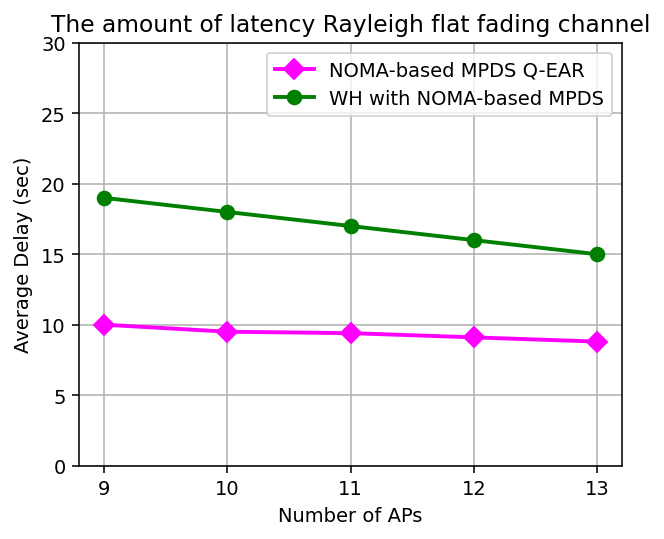

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_time_cache_1 =time_cache[:,:,9].mean()
sensor_time_cache_2 =time_cache[:,:,10].mean()
sensor_time_cache_3 =time_cache[:,:,11].mean()
sensor_time_cache_4 =time_cache[:,:,12].mean()
sensor_time_cache_5 =time_cache[:,:,13].mean()
xpoints = [9, 10, 11, 12, 13]
ypoints = [sensor_time_cache_1, sensor_time_cache_2, sensor_time_cache_3, sensor_time_cache_4, sensor_time_cache_5]
plt.plot(xpoints,ypoints, label = 'NOMA-based MPDS Q-EAR',color='magenta', lw=2,markerfacecolor='magenta',marker='D', ms=7) # circle
sensor_time_cache_1 =time_cache_2[:,:,9].mean()
sensor_time_cache_2 =time_cache_2[:,:,10].mean()
sensor_time_cache_3 =time_cache_2[:,:,11].mean()
sensor_time_cache_4 =time_cache_2[:,:,12].mean()
sensor_time_cache_5 =time_cache_2[:,:,13].mean()
xpoints = [9, 10, 11, 12, 13]
ypoints = [sensor_time_cache_1, sensor_time_cache_2, sensor_time_cache_3, sensor_time_cache_4, sensor_time_cache_5]
plt.plot(xpoints,ypoints, label = 'WH with NOMA-based MPDS',color='green', lw=2,markerfacecolor='green',marker='o', ms=7) # circle
plt.yticks([15, 20, 25, 30, 35, 40, 45, 50, 55])
plt.xticks([9, 10, 11, 12, 13])
plt.xlabel('Number of APs')
plt.ylabel('Average Delay (sec)')
plt.grid(True)
plt.title('The amount of latency Rayleigh flat fading channel')
plt.legend()
plt.show()
plt.close()

#**MPDS - Effective Thrughput(bps) - Number of Patients - NOMA - Rayleigh**

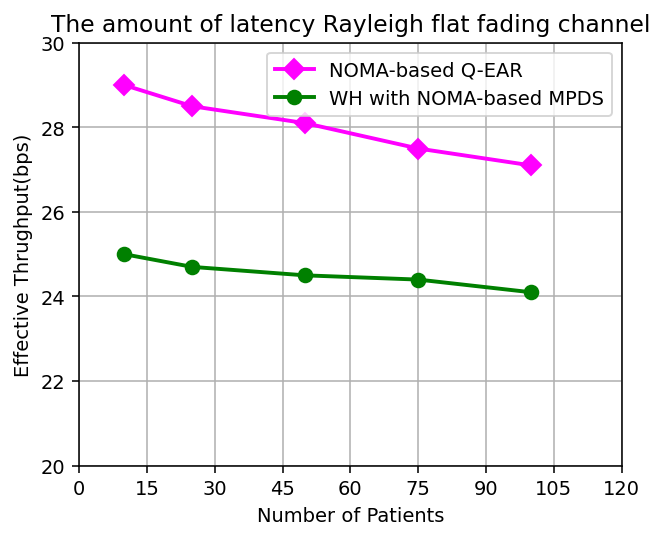

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_throughput_1 =  throughput_cache[:, 10,:].mean()
sensor_throughput_2 =  throughput_cache[:, 25,:].mean()
sensor_throughput_3 =  throughput_cache[:, 50,:].mean()
sensor_throughput_4 =  throughput_cache[:, 75,:].mean()
sensor_throughput_5 =  throughput_cache[:, 100,:].mean()
xpoints = [10, 25, 50, 75, 100]
ypoints = [sensor_throughput_1 ,sensor_throughput_2 ,sensor_throughput_3 ,sensor_throughput_4 ,sensor_throughput_5 ]
plt.plot(xpoints,ypoints, label = 'NOMA-based Q-EAR',color='magenta', lw=2,markerfacecolor='magenta',marker='D', ms=7) # circle
sensor_throughput_1 =  throughput_cache_2[:, 10,:].mean()
sensor_throughput_2 =  throughput_cache_2[:, 25,:].mean()
sensor_throughput_3 =  throughput_cache_2[:, 50,:].mean()
sensor_throughput_4 =  throughput_cache_2[:, 75,:].mean()
sensor_throughput_5 =  throughput_cache_2[:, 100,:].mean()
xpoints = [10, 25, 50, 75, 100]
ypoints = [sensor_throughput_1 ,sensor_throughput_2 ,sensor_throughput_3 ,sensor_throughput_4 ,sensor_throughput_5 ]
plt.plot(xpoints,ypoints, label = 'WH with NOMA-based MPDS',color='green', lw=2,markerfacecolor='green',marker='o', ms=7) # circle
plt.yticks([18, 20, 22, 24, 26, 28, 30])
plt.xticks([10, 25, 50, 75, 100])
plt.xlabel('Number of Patients')
plt.ylabel('Effective Thrughput(bps)')
plt.grid(True)
plt.title('The amount of latency Rayleigh flat fading channel')
plt.legend(loc='upper right')
plt.show()

#**Effective Thrughput(bps) - Number of Access Points- NOMA - Rayleigh**

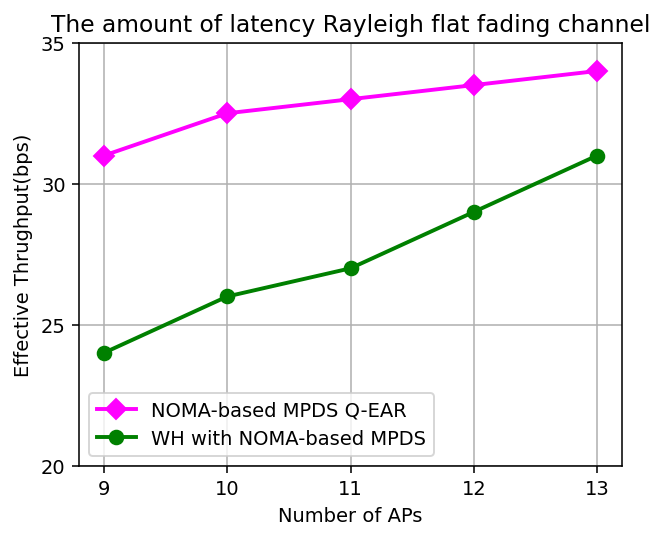

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_throughput_2 =  throughput_cache[:,:,10].mean()
sensor_throughput_3 =  throughput_cache[:,:,11].mean()
sensor_throughput_4 =  throughput_cache[:,:,12].mean()
sensor_throughput_5 =  throughput_cache[:,:,13].mean()
xpoints_eeg_4 = [9, 10, 11, 12, 13]
ypoints_eeg_4 = [sensor_throughput_1, sensor_throughput_2, sensor_throughput_3, sensor_throughput_4, sensor_throughput_5]
plt.plot(xpoints_eeg_4,ypoints_eeg_4, label = 'NOMA-based MPDS Q-EAR',color='magenta', lw=2,markerfacecolor='magenta',marker='D', ms=7) # circle
sensor_throughput_2 =  throughput_cache_2[:,:,10].mean()
sensor_throughput_3 =  throughput_cache_2[:,:,11].mean()
sensor_throughput_4 =  throughput_cache_2[:,:,12].mean()
sensor_throughput_5 =  throughput_cache_2[:,:,13].mean()
xpoints_eeg_4 = [9, 10, 11, 12, 13]
ypoints_eeg_4 = [sensor_throughput_1, sensor_throughput_2, sensor_throughput_3, sensor_throughput_4, sensor_throughput_5]
xpoints_eeg_1 = [9, 10, 11, 12, 13]
ypoints_eeg_1 = [24, 26, 27, 29, 31]
plt.plot(xpoints_eeg_1,ypoints_eeg_1, label = 'WH with NOMA-based MPDS',color='green', lw=2,markerfacecolor='green',marker='o', ms=7) # circle
plt.yticks([ 20, 25, 30, 35])
plt.xticks([9, 10, 11, 12, 13])
plt.xlabel('Number of APs')
plt.ylabel('Effective Thrughput(bps)')
plt.grid(True)
plt.title('The amount of latency Rayleigh flat fading channel')
plt.legend(loc='lower left')
plt.show()

#**Average Energy Consumption (J) - Number of Patients- NOMA - Rayleigh**

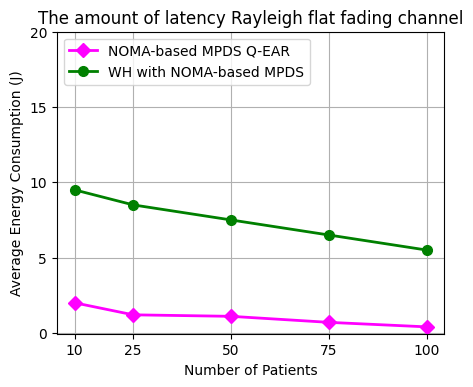

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_energy_1 = energy_cache[:, 10, :].mean()
sensor_energy_2 = energy_cache[:, 25, :].mean()
sensor_energy_3 = energy_cache[:, 50, :].mean()
sensor_energy_4 = energy_cache[:, 75, :].mean()
sensor_energy_5 = energy_cache[:, 100,:].mean()
xpoints_eeg_4 = [10, 25, 50, 75, 100]
ypoints_eeg_4 = [sensor_time_cache_1, sensor_time_cache_2, sensor_time_cache_3, sensor_time_cache_4, sensor_time_cache_5]
plt.plot(xpoints_eeg_4,ypoints_eeg_4, label = 'NOMA-based MPDS Q-EAR',color='magenta', lw=2,markerfacecolor='magenta',marker='D', ms=7) # circle
sensor_energy_1 = energy_cache_2[:, 10, :].mean()
sensor_energy_2 = energy_cache_2[:, 25, :].mean()
sensor_energy_3 = energy_cache_2[:, 50, :].mean()
sensor_energy_4 = energy_cache_2[:, 75, :].mean()
sensor_energy_5 = energy_cache_2[:, 100,:].mean()
xpoints_eeg_4 = [10, 25, 50, 75, 100]
ypoints_eeg_4 = [sensor_time_cache_1, sensor_time_cache_2, sensor_time_cache_3, sensor_time_cache_4, sensor_time_cache_5]
plt.plot(xpoints_eeg_4,ypoints_eeg_4, label = 'WH with NOMA-based MPDS',color='green', lw=2,markerfacecolor='green',marker='o', ms=7) # circle
plt.yticks([0, 10, 20, 30, 40, 50,60, 70, 80])
plt.xticks([10, 25, 50, 75, 100])
plt.xlabel('Number of Patients')
plt.ylabel('Average Energy Consumption (J)')
plt.grid(True)
plt.title('The amount of latency Rayleigh flat fading channel')
plt.legend(loc='upper left')
plt.show()

#**Average Energy Consumption (J)  - Number of Access Points- NOMA - Rayleigh**

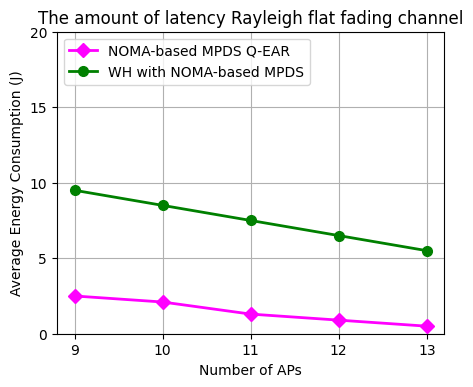

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 100)
sensor_energy_1 = energy_cache[:,:,9].mean()
sensor_energy_2 = energy_cache[:,:,10].mean()
sensor_energy_3 = energy_cache[:,:,11].mean()
sensor_energy_4 = energy_cache[:,:,12].mean()
sensor_energy_5 = energy_cache[:,:,13].mean()
xpoints_eeg_4 = [9, 10, 11, 12, 13]
ypoints_eeg_4 = [sensor_energy_1, sensor_energy_2,sensor_energy_3,sensor_energy_4,sensor_energy_5]
plt.plot(xpoints_eeg_4,ypoints_eeg_4, label = 'NOMA-based MPDS Q-EAR',color='magenta', lw=2,markerfacecolor='magenta',marker='D', ms=7) # circle
sensor_energy_1 = energy_cache_2[:,:,9].mean()
sensor_energy_2 = energy_cache_2[:,:,10].mean()
sensor_energy_3 = energy_cache_2[:,:,11].mean()
sensor_energy_4 = energy_cache_2[:,:,12].mean()
sensor_energy_5 = energy_cache_2[:,:,13].mean()
xpoints_eeg_4 = [9, 10, 11, 12, 13]
ypoints_eeg_4 = [sensor_energy_1, sensor_energy_2,sensor_energy_3,sensor_energy_4,sensor_energy_5]
plt.plot(xpoints_eeg_1,ypoints_eeg_1, label = 'WH with NOMA-based MPDS',color='green', lw=2,markerfacecolor='green',marker='o', ms=7) # circle
plt.yticks([0, 10, 20, 30, 40, 50,60, 70, 80])
plt.xticks([9, 10, 11, 12, 13])
plt.xlabel('Number of APs')
plt.ylabel('Average Energy Consumption (J)')
plt.grid(True)
plt.title('The amount of latency Rayleigh flat fading channel')
plt.legend(loc='center left')
plt.show()

#**Velocity (m/s)  - Average Delay (sec) - Q-EAR vs WH with NOMA based MPDS**

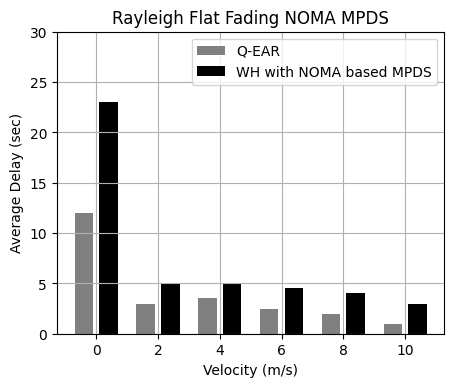

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
i, j, ap =np.where(velocity_cache==0)
value1=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==2)
value2=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==4)
value3=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==6)
value4=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==8)
value5=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==10)
value6=time_cache[i, j, ap]
data = {'0':value1, '2':value2, '4':value3, '6':value4, '8':value5, '10':value6}
velocity = list(data.keys())
values = list(data.values())
figure(figsize = (5, 4), dpi = 100)
data2 = {'0':23, '2':5, '4':5, '6':4.5, '8':4, '10':3}
velocity2 = list(data2.keys())
values2 = list(data2.values())
velocity = ['0','2','4','6','8','10']
X_axis = np.arange(len(velocity))
figure(figsize = (5, 4), dpi = 100)
# creating the bar plot
plt.bar(X_axis - 0.2, values, color ='gray', width = 0.3, label = 'Q-EAR')
i, j, ap =np.where(velocity_cache==0)
value1=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==2)
value2=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==4)
value3=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==6)
value4=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==8)
value5=time_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==10)
value6=time_cache[i, j, ap]
data = {'0':value1, '2':value2, '4':value3, '6':value4, '8':value5, '10':value6}
velocity = list(data.keys())
values = list(data.values())
plt.bar(X_axis + 0.2, values2, color ='black', width = 0.3, label = 'WH with NOMA based MPDS')
plt.yticks([0, 5, 10, 15, 20, 25, 30])
plt.xticks(X_axis, velocity)
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel("Velocity (m/s)")
plt.ylabel("Average Delay (sec)")
plt.title("Rayleigh Flat Fading NOMA MPDS")
plt.show()
plt.close()

#**Velocity (m/s)  - Effective Thrughput(bps) - Q-EAR vs WH with NOMA based MPDS**

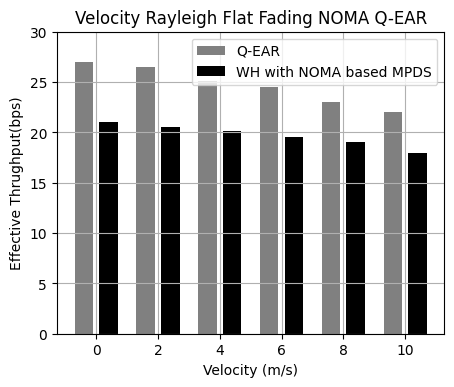

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
i, j, ap =np.where(velocity_cache==0)
value1=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==2)
value2=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==4)
value3=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==6)
value4=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==8)
value5=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==10)
value6=throughput_cache[i, j, ap]
velocity = ['0','2','4','6','8','10']
X_axis = np.arange(len(velocity))
plt.bar(X_axis - 0.2, values, color ='gray', width = 0.3, label = 'Q-EAR')
velocity = list(data.keys())
values = list(data.values())
figure(figsize = (5, 4), dpi = 100)
# creating the bar plot
plt.bar(X_axis + 0.2, values2, color ='black', width = 0.3, label = 'WH with NOMA based MPDS')
i, j, ap =np.where(velocity_cache==0)
value1=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==2)
value2=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==4)
value3=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==6)
value4=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==8)
value5=throughput_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==10)
value6=throughput_cache[i, j, ap]
data = {'0':value1, '2':value2, '4':value3, '6':value4, '8':value5, '10':value6}
velocity = list(data.keys())
values = list(data.values())
velocity = ['0','2','4','6','8','10']
plt.yticks([0, 5, 10, 15, 20, 25, 30])
plt.xticks(X_axis, velocity)
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel("Velocity (m/s)")
plt.ylabel('Effective Thrughput(bps)')
plt.title("Velocity Rayleigh Flat Fading NOMA MPDS")
plt.show()
plt.close()

#**Velocity (m/s)  - Average Energy Consumption (J) - Q-EAR vs WH with NOMA based MPDS**

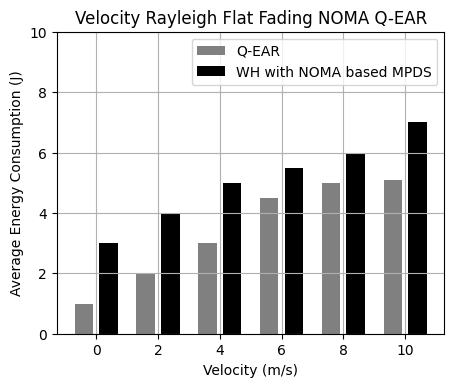

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
i, j, ap =np.where(velocity_cache==0)
value1=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==2)
value2=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==4)
value3=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==6)
value4=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==8)
value5=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==10)
value6=energy_cache[i, j, ap]
data = {'0':value1, '2':value2, '4':value3, '6':value4, '8':value5, '10':value6}
velocity = list(data.keys())
values = list(data.values())
plt.bar(X_axis - 0.2, values, color ='gray', width = 0.3, label = 'Q-EAR')
i, j, ap =np.where(velocity_cache==0)
value1=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==2)
value2=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==4)
value3=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==6)
value4=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==8)
value5=energy_cache[i, j, ap]
i, j, ap =np.where(velocity_cache==10)
value6=energy_cache[i, j, ap]
figure(figsize = (5, 4), dpi = 100)
data = {'0':value1, '2':value2, '4':value3, '6':value4, '8':value5, '10':value6}
velocity = list(data.keys())
values = list(data.values())
plt.bar(X_axis + 0.2, values2, color ='black', width = 0.3, label = 'WH with NOMA based MPDS')
velocity = ['0','2','4','6','8','10']
X_axis = np.arange(len(velocity))
plt.yticks([0, 2,4,6,8,10])
plt.xticks(X_axis, velocity)
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel("Velocity (m/s)")
plt.ylabel('Average Energy Consumption (J)')
plt.title("Velocity Rayleigh Flat Fading NOMA Q-EAR")
plt.show()
plt.close()

#**Served Failed Hub - Access Points**

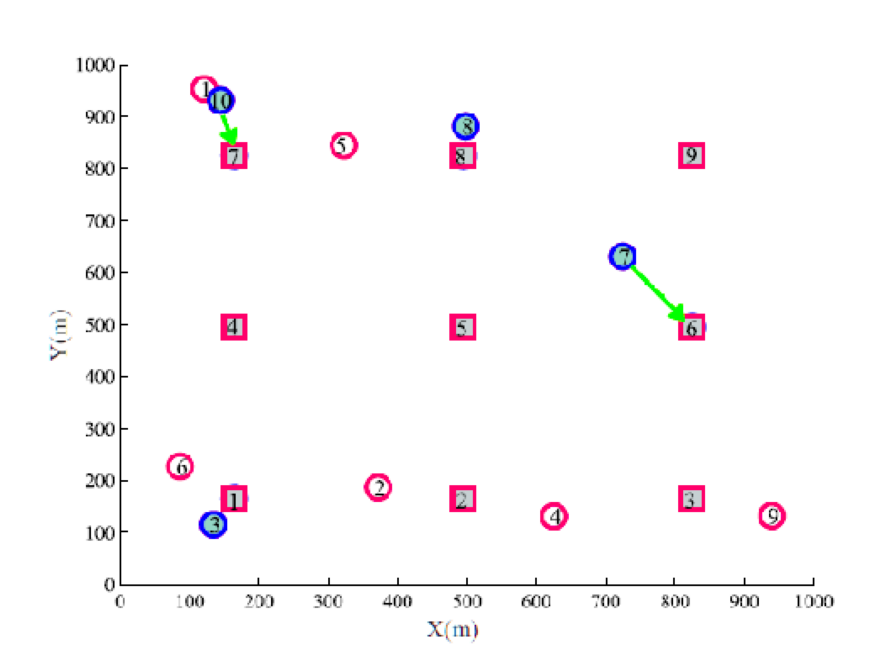

In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize = (5, 4), dpi = 220)
served=0
failed=0
sensor_energy_1 = energy_cache[:,:,9].mean()
sensor_energy_2 = energy_cache[:,:,10].mean()
sensor_energy_3 = energy_cache[:,:,11].mean()
sensor_energy_4 = energy_cache[:,:,12].mean()
sensor_energy_5 = energy_cache[:,:,13].mean()
if sensor_energy_1 > sensor_energy_2:
  served =1
elif sensor_energy_1 < sensor_energy_2:
  failed =1
elif sensor_energy_2 < sensor_energy_3:
  failed =1
elif sensor_energy_2 > sensor_energy_3:
  failed =1
elif sensor_energy_3 < sensor_energy_4:
  failed =1
elif sensor_energy_3 > sensor_energy_4:
  failed =1
elif sensor_energy_4 < sensor_energy_5:
  failed =1
elif sensor_energy_14 > sensor_energy_5:
  failed =1
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlabel("X(m)")
plt.ylabel('Y(m)')
plt.show()
plt.close()